# Import

In [44]:
import numpy as np
from scipy.stats import norm
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import statistics
from scipy import signal, stats
from cycler import cycler
from scipy.optimize import curve_fit
#import pandas as pd

In [45]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
%matplotlib inline

In [46]:
def get_plot_data(ax, filename) :
    header = ax.get_xlabel()
    data = ax.lines[0].get_xdata()
    for line in ax.lines :
        header = header + ' ' + line.get_label() 
        data = np.vstack((data,line.get_ydata()))
    data = np.transpose(data)
    np.savetxt(filename+'.dat', data, fmt='%.18e', delimiter=' ', newline='\n', header=header, footer='', comments='# ', encoding=None)
    return ('saved to ' + filename) 

In [47]:
def get_plot_data_blocks(ax, filename) :
    for line in ax.lines :
        header = ax.get_xlabel() + ' ' + line.get_label() 
        data = np.vstack((line.get_xdata(),line.get_ydata()))
        data = np.transpose(data)
        np.savetxt(filename+'_'+line.get_label()+'.dat', data, fmt='%.18e', delimiter=' ', newline='\n', header=header, footer='', comments='# ', encoding=None)
    return ('saved to ' + filename) 

# Data structure

In [48]:
simulations = [{'Sc': 500.0, 'f' : 2, 'N': 64, 'u': 0.0, 'A' : 0.0, 'folder' : 'D0zero/', 'runs': [440], 'D0': 0.0, 'spec_ite' : 900000, 'field_ite' : 900000},
        {'Sc': 500.0, 'f' : 2, 'N': 64, 'u': 2.86, 'A' : 2.86, 'folder' : 'N64/', 'runs': [440], 'D0': 4.18254881E-003, 'spec_ite' : 900000, 'field_ite' : 900000}, 
        {'Sc': 500.0, 'f' : 3, 'N': 96, 'u': 3.05, 'A' : 2.91, 'folder' : 'N96/', 'runs': [217,101], 'D0': 6.273823215E-003, 'spec_ite' : 312000, 'field_ite' : 80000}, 
        {'Sc': 500.0, 'f' : 4, 'N': 128, 'u': 3.53, 'A' : 2.93, 'folder' : 'N128/', 'runs': [89,177], 'D0': 8.3650976202353233E-003, 'spec_ite' : 727000, 'field_ite' : 365000}, 
        {'Sc': 500.0, 'f' : 6, 'N': 192, 'u': 4.34, 'A' : 2.95, 'folder' : 'N192/', 'runs': [17,18,60], 'D0': 12.54764643E-003, 'spec_ite' : 373000, 'field_ite' : 110000},
        {'Sc': 500.0, 'f' : 8, 'N': 256, 'u': 5.03, 'A' : 2.97, 'folder' : 'N256/', 'runs': [10,10,9,10,10], 'D0': 16.73019524E-003, 'spec_ite' : 93000, 'field_ite' : 90000},
        {'Sc': 500.0, 'f' : 12, 'N': 384, 'u': 6.16, 'A' : 2.97, 'folder' : 'N384/', 'runs': [263], 'D0': 25.09529286E-003, 'spec_ite' : 101000, 'field_ite' : 70000},
        {'Sc': 500.0, 'f' : 16, 'N': 512, 'u': 7.12, 'A' : 2.98, 'folder' : 'N512/', 'runs': [6,7,7,7,8], 'D0': 33.46039048E-003, 'spec_ite' : 20000, 'field_ite' : 10000},
        {'Sc': 500.0, 'f' : 32, 'N': 768, 'u': 8.74, 'A' : 2.98, 'folder' : 'N768/', 'runs': [21,21,21,21], 'D0': 50.19058572E-003, 'spec_ite' : 21000, 'field_ite' : 10000}]

In [49]:
set2 = [{'Sc': 500.0, 'f' : 32, 'N': 1024, 'u': 8.74, 'folder' : 'N1024/', 'runs': [2], 'D0': 50.19058572E-003, 'spec_ite' : 2000, 'field_ite' : 10000},
        {'Sc': 2000.0, 'f' : 12, 'N': 256, 'u': 8.74, 'folder' : 'Sc2000_N256/', 'runs': [6], 'D0': 12.54764643E-003, 'spec_ite' : 89000, 'field_ite' : 85000},
        {'Sc': 2000.0, 'f' : 12, 'N': 256, 'u': 8.74, 'folder' : 'Sc2000_N256_Te3/', 'runs': [6], 'D0': 12.54764643E-003, 'spec_ite' : 93000, 'field_ite' : 85000},
        {'Sc': 2500.0, 'f' : 12, 'N': 256, 'u': 8.74, 'folder' : 'Sc2500_N256/', 'runs': [6], 'D0': 12.54764643E-003, 'spec_ite' : 92000, 'field_ite' : 90000},
        {'Sc': 500.0, 'f' : 24, 'N': 384, 'u': 4.36, 'A' : 2.97, 'folder' : 'N384/largeTe/', 'runs': [258], 'D0': 25.09529286E-003, 'spec_ite' : 99000, 'field_ite' : 70000}]

In [50]:
eps = 1.0
viscosity = 1.0

In [51]:
for simu in np.concatenate((simulations,set2)) :
    simu.update({'diffusivity': viscosity/simu["Sc"]})

# Reading data

In [52]:
#read correlation files
def read_data_file(common_folder, scalar, file_type, spec_type, spec_component, run_files) :
    nb_of_runs = len(run_files)
    if (nb_of_runs > 0) :
        for run_index in list(range(nb_of_runs)) :
            folder = common_folder + "run" + "%01d" % (run_index+1) + "/"
            if (run_files[run_index] < 1000) :
                file = folder + "scalar%01d" %scalar + "_" + file_type + "_" + spec_type + "_C" + spec_component + "_wi=" + "%03d" % run_files[run_index] + ".table"
            else : 
                file = folder + file_type + "_" + spec_type + "_C" + spec_component + "_wi=" + "%06d" % run_files[run_index] + ".table"
            file_data = []
            print('reading file: ' + file)
            averaging_weight = (run_files[run_index]+1)/(sum(run_files)+nb_of_runs)
            for line in open(file) :
                temp_array_line = []
                if line[0] == '#' :          #skip commented lines
                    continue
                else :
                    temp_array_line=list(map(float, line.split( )))
                    temp_array_line = [t * averaging_weight for t in temp_array_line]
                    file_data.append(temp_array_line)  
            if (run_index == 0) : 
                accumulated_data = file_data.copy()
            else : 
                accumulated_data = list(map(lambda l1, l2: [sum(x) for x in zip(l1, l2)], accumulated_data, file_data))
        k = np.array(accumulated_data[0])
        nb_of_modes = np.array(accumulated_data[1])
        average_data = np.ndarray(shape=(len(accumulated_data)-2, k.shape[0]+1), dtype=float)
        for i in list(range(average_data.shape[0])) : 
            average_data[i, :] = np.array(accumulated_data[i+2])
        t = average_data[:,0]
        numpy_file_table = np.array(average_data[:,1:])
        return [k, nb_of_modes, t, numpy_file_table]
    else :
        return [0, 0, 0, 0]

In [53]:
def read_spec_file(common_folder, forlder_in, quantity, spec_type, ite) :
    file = common_folder + forlder_in + quantity + "_" + spec_type + "_ite=%06d" % ite + ".table"
    print('reading file: ' + file)
    file_data = []
    for line in open(file) :
        temp_array_line = []
        if line[0] == '#' :          #skip commented lines
            continue
        else :
            temp_array_line=list(map(float, line.split( )))
            file_data.append(temp_array_line)  
    spec_table = np.array(file_data)
    k = spec_table[:,0]
    nb_of_modes = spec_table[:,1]
    Ek = spec_table[:,2]
#     Exx = spec_table[:,3]
#     Eyy = spec_table[:,4]
#     Ezz = spec_table[:,5]
    #return [k, nb_of_modes, Ek, Exx, Eyy, Ezz, spec_table[:,6], spec_table[:,7], spec_table[:,8], spec_table[:,9]]
    return [k, nb_of_modes, Ek]

In [54]:
common_folder = "/robin/data/gorbunov8a/data/random_advection/eps_dep/Sc500/e1/"
spec_type = "lin"
spec_component = "avg"
sca = 1
file_type = "two_point_corr_complex"

In [55]:
# read data files
for simu in simulations: 
    [k, nb_of_modes, time, two_point_corr] = read_data_file(common_folder + simu['folder'], 1, file_type, spec_type, spec_component, simu['runs'])
    simu.update({'corr': two_point_corr, 't': time, 'k' : k, 'nb_of_modes' : nb_of_modes})
    [k, nb_of_modes, spec] = read_spec_file(common_folder + simu['folder'], "run" + "%01d" % (len(simu['runs'])) + "/", "spectrum_scalar1", "lin", simu['spec_ite'])
    simu.update({'spec': spec})

reading file: /robin/data/gorbunov8a/data/random_advection/eps_dep/Sc500/e1/D0zero/run1/scalar1_two_point_corr_complex_lin_Cavg_wi=440.table
reading file: /robin/data/gorbunov8a/data/random_advection/eps_dep/Sc500/e1/D0zero/run1/spectrum_scalar1_lin_ite=900000.table
reading file: /robin/data/gorbunov8a/data/random_advection/eps_dep/Sc500/e1/N64/run1/scalar1_two_point_corr_complex_lin_Cavg_wi=440.table
reading file: /robin/data/gorbunov8a/data/random_advection/eps_dep/Sc500/e1/N64/run1/spectrum_scalar1_lin_ite=900000.table
reading file: /robin/data/gorbunov8a/data/random_advection/eps_dep/Sc500/e1/N96/run1/scalar1_two_point_corr_complex_lin_Cavg_wi=217.table
reading file: /robin/data/gorbunov8a/data/random_advection/eps_dep/Sc500/e1/N96/run2/scalar1_two_point_corr_complex_lin_Cavg_wi=101.table
reading file: /robin/data/gorbunov8a/data/random_advection/eps_dep/Sc500/e1/N96/run2/spectrum_scalar1_lin_ite=312000.table
reading file: /robin/data/gorbunov8a/data/random_advection/eps_dep/Sc500/

In [56]:
for simu in set2: 
    [k, nb_of_modes, time, two_point_corr] = read_data_file(common_folder + simu['folder'], 1, file_type, spec_type, spec_component, simu['runs'])
    simu.update({'corr': two_point_corr, 't' : time})
    [k, nb_of_modes, spec] = read_spec_file(common_folder + simu['folder'], "run1/", "spectrum_scalar1", "lin", simu['spec_ite'])
    simu.update({'k' : k, 'nb_of_modes' : nb_of_modes, 'spec': spec})

reading file: /robin/data/gorbunov8a/data/random_advection/eps_dep/Sc500/e1/N1024/run1/scalar1_two_point_corr_complex_lin_Cavg_wi=002.table
reading file: /robin/data/gorbunov8a/data/random_advection/eps_dep/Sc500/e1/N1024/run1/spectrum_scalar1_lin_ite=002000.table
reading file: /robin/data/gorbunov8a/data/random_advection/eps_dep/Sc500/e1/Sc2000_N256/run1/scalar1_two_point_corr_complex_lin_Cavg_wi=006.table
reading file: /robin/data/gorbunov8a/data/random_advection/eps_dep/Sc500/e1/Sc2000_N256/run1/spectrum_scalar1_lin_ite=089000.table
reading file: /robin/data/gorbunov8a/data/random_advection/eps_dep/Sc500/e1/Sc2000_N256_Te3/run1/scalar1_two_point_corr_complex_lin_Cavg_wi=006.table
reading file: /robin/data/gorbunov8a/data/random_advection/eps_dep/Sc500/e1/Sc2000_N256_Te3/run1/spectrum_scalar1_lin_ite=093000.table
reading file: /robin/data/gorbunov8a/data/random_advection/eps_dep/Sc500/e1/Sc2500_N256/run1/scalar1_two_point_corr_complex_lin_Cavg_wi=006.table
reading file: /robin/data/g

# Parameters

In [57]:
# Plotting options
plt.rc('axes', labelsize=16)  
plt.rc('axes', titlesize=16)  
plt.rc('legend', fontsize=14)  

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#1f77b4']
default_cycler = cycler(cycler(linestyle=['-', '--', ':', '-.'])*cycler(color=colors))
plt.rc('axes', prop_cycle=default_cycler)

In [58]:
kmin = 8
nb_of_curves = 5

for simu in np.concatenate((simulations,set2)) :
    kmax = np.max(simu['k'])-6
    step = round((kmax - kmin)/nb_of_curves)
    simu['indices_of_k_to_plot'] = np.arange(kmin,kmax,step, dtype=np.int16)
    simu['indices_of_k_to_plot2'] = np.linspace(3/4*kmax, kmax, num=6, endpoint=False, dtype=int)
    print(simu['indices_of_k_to_plot2'])
    simu['Te'] = (simu['t'][1]-simu['t'][0])*simu['f']

[19 20 21 22 23 24]
[19 20 21 22 23 24]
[31 33 34 36 38 39]
[43 45 48 50 52 55]
[67 71 74 78 82 86]
[ 91  96 101 106 111 116]
[139 147 154 162 170 178]
[187 197 208 218 228 239]
[283 299 314 330 346 362]
[379 400 421 442 463 484]
[ 91  96 101 106 111 116]
[ 91  96 101 106 111 116]
[ 91  96 101 106 111 116]
[139 147 154 162 170 178]


In [59]:
def peclet(D0, l, kappa, epsilon) :
    return D0/epsilon*(l**epsilon)/kappa

In [60]:
#Scalar forcing length scale :
scalar_L = 2.0*np.pi/3.5

In [61]:
def kappa_ren(kappa,D0,A, d) :
    return (kappa + 1.0/(2.0*d)*D0*A*3.0)

In [62]:
for simu in np.concatenate((simulations,set2)) :
    simu['Pe'] = peclet(simu['D0'], scalar_L, simu['diffusivity'], 1.0)
    print(simu['Pe'])

0.0
3.7542470327933515
5.631370549190028
7.5084940657979296
11.262741098380056
15.016988131173406
22.525482196760112
30.033976262346812
45.050964393520225
45.050964393520225
45.050964393520225
45.050964393520225
56.31370549190027
22.525482196760112


In [63]:
def diffusion_length_scale(D0, kappa, epsilon) :
    return (kappa/D0)**(1.0/epsilon)

In [64]:
for simu in np.concatenate((simulations[1::],set2)) :
    simu['rd'] = diffusion_length_scale(simu['D0'], simu['diffusivity'], 1.0)
    print(simu['rd'])

0.47817732460604573
0.31878488307069713
0.23908866229629688
0.15939244153534857
0.11954433115151143
0.07969622076767428
0.059772165575755716
0.03984811038383714
0.03984811038383714
0.03984811038383714
0.03984811038383714
0.03187848830706971
0.07969622076767428


$\Delta t /\tau_0 $

In [65]:
for simu in np.concatenate((simulations[1::],set2[-1:])) :
    tau0 = scalar_L/simu['u']
    print('%2.2e' % ((simu['t'][1] - simu['t'][0])/tau0))

1.56e-03
1.11e-03
9.65e-04
7.91e-04
6.88e-04
5.61e-04
4.87e-04
2.99e-04
3.97e-04


In [66]:
for simu in np.concatenate((simulations[1::],set2[-1:])) :
    tau0 = scalar_L/simu['u']
    #print('%2.3e' % (simu['Te']/tau0))
    print(tau0)

0.6276908398780806
0.5885887875578067
0.5085540515726092
0.41363958572610837
0.35689777376765613
0.2914278899433945
0.2521342418611391
0.2053999773514085
0.41174215643378675


In [67]:
for simu in set2 :
    print(simu['t'][-1]/simu['Te'])

20.343730035593687
1018.5790679908326
1018.5790679908326
1018.5790679908326
12.708301502419149


# Spectra

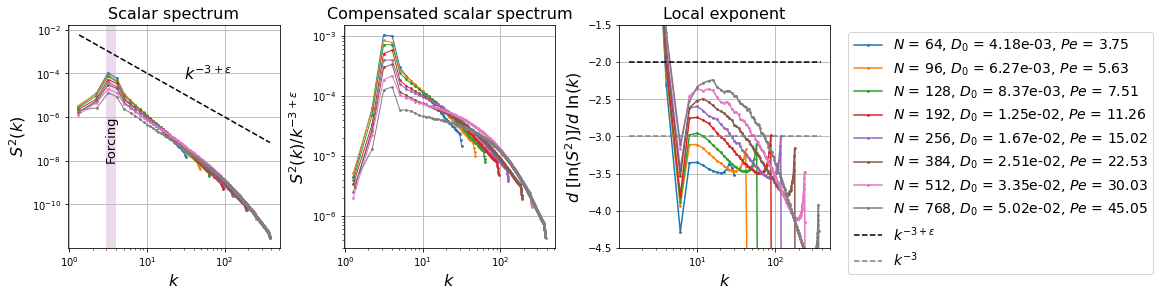

In [68]:
resampling = 2
sl = np.s_[1:-1:resampling]
fig, ax = plt.subplots(ncols=3, nrows=1, constrained_layout=True, figsize=(16,4))
#for sca in range(len(scalars)) :
for simu in simulations[1::] :
    spherical_coef = 4.0*np.pi*simu['k']**2/simu['nb_of_modes']
    ax[0].plot(simu['k'], (simu['spec']*spherical_coef), '.-', lw=1.0, markersize=3.5)
    ax[1].plot(simu['k'], (simu['spec']*spherical_coef)/(simu['k']**(-3+eps)), '.-', lw=1.0, markersize=3.5)

    slope = np.gradient(np.log((simu["spec"]*spherical_coef)[sl]), np.log(simu['k'][sl]))
    ax[2].plot(simu['k'][sl], slope, '.-', markersize=3.5, label=r'$N$ = %2.0f, $D_0$ = %2.2e, $Pe$ = %2.2f' % (simu['N'], simu['D0'], simu['Pe']))
ax[0].plot(simu['k'],10e-3*simu['k']**(-3+eps), 'k--'); ax[0].annotate(r'$k^{-3+\epsilon}$', xy=(30, 0.5e-4), xycoords='data', size='16', color='k')
ax[2].plot(simu['k'], np.full_like(simu['k'], (-3.0+eps), dtype=float), 'k--', label=r'$k^{-3+\epsilon}$')
ax[2].plot(simu['k'], np.full_like(simu['k'], (-3.0), dtype=float), '--', label=r'$k^{-3}$', color='gray')

ax[0].axvspan(3.0, 4.0, facecolor='purple', alpha=0.15)
ax[0].text(3.5, 10e-8, "Forcing", {'color': 'black', 'fontsize': 13},horizontalalignment='center',verticalalignment='center',rotation=90,clip_on=False)
ax[0].set(xscale='log', yscale='log', xlabel=r'$k$', ylabel=r'$S^2(k)$', title=r'Scalar spectrum'); ax[0].grid()
ax[1].set(xscale='log', yscale='log', xlabel=r'$k$', ylabel=r'$S^2(k)/k^{-3+\epsilon}$', title=r'Compensated scalar spectrum'); ax[1].grid()
ax[2].set(xscale='log', yscale='linear', title='Local exponent', xlabel=r'$k$', ylabel=r'$d\ [\ln(S^2)]/d\ \ln (k)$'); ax[2].grid()
ax[2].set(ylim=[-4.5,-1.5])
#ax[1].set(ylim=[10e-7,5e-3])
lgd = ax[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# pp = PdfPages('../Images/Scalar/Sc500_diff_D0_spec_scalar.pdf')
# pp.savefig(bbox_extra_artists=(lgd, ), bbox_inches='tight')
# pp.close()

plt.show()

In [69]:
for simu in simulations :
    print(np.sum(4.0*np.pi*simu['k']**2/simu['nb_of_modes']*simu['spec']))

0.00038221491031807035
0.00020847758658807145
0.000175003980271068
0.00015380540749105668
0.00011717889319967713
9.13254002131417e-05
7.327325265157925e-05
5.306218035280309e-05
3.563250967853427e-05


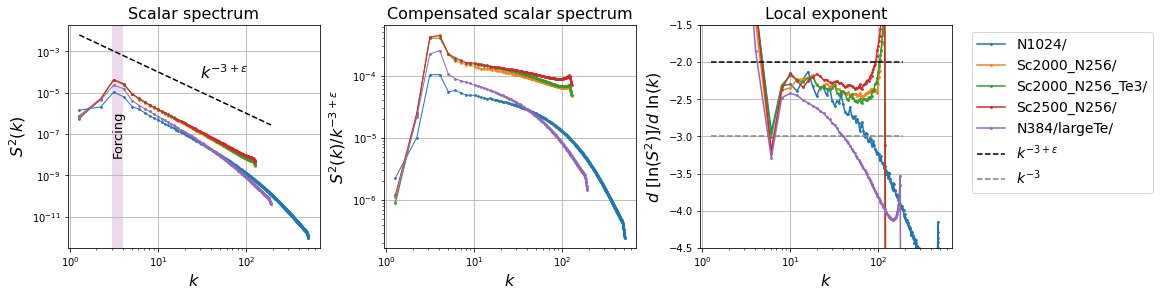

In [70]:
resampling = 2
sl = np.s_[1:-1:resampling]
fig, ax = plt.subplots(ncols=3, nrows=1, constrained_layout=True, figsize=(16,4))
#for sca in range(len(scalars)) :
for simu in set2 :
    spherical_coef = 4.0*np.pi*simu['k']**2/simu['nb_of_modes']
    ax[0].plot(simu['k'], (simu['spec']*spherical_coef), '.-', lw=1.0, markersize=3.5)
    ax[1].plot(simu['k'], (simu['spec']*spherical_coef)/(simu['k']**(-3+eps)), '.-', lw=1.0, markersize=3.5)

    slope = np.gradient(np.log((simu["spec"]*spherical_coef)[sl]), np.log(simu['k'][sl]))
    ax[2].plot(simu['k'][sl], slope, '.-', markersize=3.5, label=simu['folder'])
ax[0].plot(simu['k'],10e-3*simu['k']**(-3+eps), 'k--'); ax[0].annotate(r'$k^{-3+\epsilon}$', xy=(30, 0.5e-4), xycoords='data', size='16', color='k')
ax[2].plot(simu['k'], np.full_like(simu['k'], (-3.0+eps), dtype=float), 'k--', label=r'$k^{-3+\epsilon}$')
ax[2].plot(simu['k'], np.full_like(simu['k'], (-3.0), dtype=float), '--', label=r'$k^{-3}$', color='gray')

ax[0].axvspan(3.0, 4.0, facecolor='purple', alpha=0.15)
ax[0].text(3.5, 10e-8, "Forcing", {'color': 'black', 'fontsize': 13},horizontalalignment='center',verticalalignment='center',rotation=90,clip_on=False)
ax[0].set(xscale='log', yscale='log', xlabel=r'$k$', ylabel=r'$S^2(k)$', title=r'Scalar spectrum'); ax[0].grid()
ax[1].set(xscale='log', yscale='log', xlabel=r'$k$', ylabel=r'$S^2(k)/k^{-3+\epsilon}$', title=r'Compensated scalar spectrum'); ax[1].grid()
ax[2].set(xscale='log', yscale='linear', title='Local exponent', xlabel=r'$k$', ylabel=r'$d\ [\ln(S^2)]/d\ \ln (k)$'); ax[2].grid()
ax[2].set(ylim=[-4.5,-1.5])
#ax[1].set(ylim=[10e-7,5e-3])
lgd = ax[2].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

# 2-point time correlations

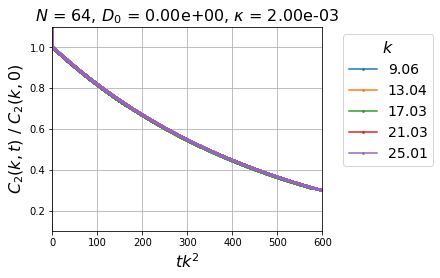

In [71]:
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(6,3.75))
simu = simulations[0]
corr = simu['corr']
for index,ik in enumerate(simu['indices_of_k_to_plot']) :
    xscaling = simu['k'][ik]**2
    ax.plot(simu['t'][0:]*xscaling, corr[0:,ik]/corr[1,ik], '.-', markersize=3.5, label=r'%2.2f' % (simu['k'][ik]), color=colors[index])
ax.set(xscale='linear',yscale='linear', xlabel=r'$t k^2$', ylabel=r'$C_2(k, t) \ / \ C_2(k,0)$', title=r'$N$ = %2.0f, $D_0$ = %2.2e, $\kappa$ = %2.2e' % (simu['N'],simu['D0'],simu['diffusivity'])); ax.grid()
ax.set(xlim=[0,600],ylim=[1e-1,1.1])
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left',title=r'$k$',fontsize=14, title_fontsize=16)
# pp = PdfPages('../Images/Scalar/corr_data_and_fit_eps1_N128_Sc500.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()
plt.show()

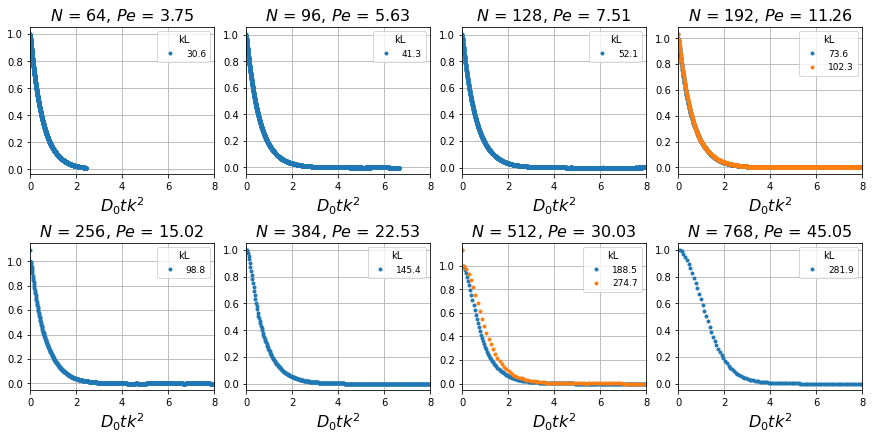

In [72]:
nb_of_rows = 2
nb_of_cols = 4
fig, ax = plt.subplots(nrows=nb_of_rows, ncols=nb_of_cols, constrained_layout=True,figsize=(12,6), squeeze=False)
for index, simu in np.ndenumerate(simulations[1::]):
    i = index[0]
    row = i//nb_of_cols; col = i - (row*nb_of_cols)
    for ik in simu['indices_of_k_to_plot'][2:-2:] :
        xscaling = simu['D0']*simu['k'][ik]**2
        #xscaling = 1.0
        ax[row,col].plot(simu['t']*xscaling, simu['corr'][:,ik]/simu['corr'][1,ik], '.', label=r'%2.1f' % (simu['k'][ik]*scalar_L))
    ax[row,col].set(xscale='linear',yscale='linear', xlabel=r'$D_0 t k^2$', title=r'$N$ = %2.0f, $Pe$ = %2.2f' % (simu['N'],simu['Pe'])); ax[row,col].grid()
    ax[row,col].set(xlim=[0,8.0])
    ax[row,col].legend(loc='best', title='kL', fontsize=9)
# pp = PdfPages('../Images/Scalar/Sc500_diff_D0_time_corr.pdf')
# pp.savefig(bbox_inches='tight')
# pp.close()

plt.show()

# Exponential Fit

In [73]:
def simple_gaussian(x, a, c):   
    return np.exp(-a * (x)**2.0 + c) 
def simple_gaussian_jacobian(x, a, c):   
    return np.transpose([-(x**2.0)*np.exp(-a * (x)**2.0 + c), np.exp(-a * (x)**2.0 + c)])

def simple_exp(x, a, c):   
    return np.exp(-a * x + c) 
def simple_exp_jacobian(x, a, c):   
    return np.transpose([-x*np.exp(-a * x + c), np.exp(-a * x + c)])

def linear_fun(x, a, b):   
    return (a * x + b) 
def linear_jacobian(x, a, b):   
    return np.transpose([x, np.ones_like(x)])

In [74]:
def try_to_fit(curve_function, xdata, ydata, sigma_ydata=None, jacobian_function=None) :
    number_of_params_of_optimization = len(signature(curve_function).parameters)-1
    coefficients = np.ndarray(shape=(number_of_params_of_optimization), dtype=float) 
    covariance_matrix = np.ndarray(shape=(number_of_params_of_optimization, number_of_params_of_optimization), dtype=float) 
    try :
        coefficients, covariance_matrix = curve_fit(curve_function, xdata, ydata, sigma=sigma_ydata, jac=jacobian_function, absolute_sigma=False)
    except :
        #print('[DEBUG] Failed optimization for ik = ', ik)
        coefficients.fill(np.nan); covariance_matrix.fill(np.nan)
    return [coefficients, covariance_matrix]

In [75]:
def find_best_fit(data_x, data_y) :
    N = len(data_x)
    Nmin = N//min_coef
    Nmax = N-5
    a = 0; b = Nmax
    min_slope, min_intercept, r_value, p_value, min_error = stats.linregress(data_x, data_y)
    min_param = min_error/len(data_x)
    if (Nmin > 0) :
        #for i in list(range(0, N-Nmin-1)) :
        i = 0 
        for j in list(range(i+Nmin, Nmax)) :
            new_slope, new_intercept, r_value, p_value, new_error = stats.linregress(data_x[i:j], data_y[i:j])
            new_param = new_error/len(data_x[i:j])
            if (new_param < min_param) :
                min_param = new_param
                min_error = new_error; min_slope = new_slope; min_intercept = new_intercept
                a = i; b = j
    return min_slope, min_intercept, min_error, (b-a+1), a, b

In [76]:
def find_all_fits(data_x, data_y) :
    N = len(data_x)
    Nmin = N//min_coef
    Nmax = N-5
    all_slope = np.zeros(Nmax-Nmin); all_intercept = np.zeros(Nmax-Nmin); all_error = np.zeros(Nmax-Nmin)
    if (Nmin > 0) :
        #for i in list(range(0, N-Nmin-1)) :
        i = 0 
        for index, j in np.ndenumerate(list(range(i+Nmin, Nmax))):
            all_slope[index], all_intercept[index], r_value, p_value, all_error[index] = stats.linregress(data_x[i:j], data_y[i:j])
    return [all_slope, all_intercept, all_error]

In [77]:
min_coef = 5
tk2_end_fit = 3.5
for simu in simulations :
    N = len(simu['t']); Nmin = N//min_coef; Nmax = N-5
    simu['a'] = np.full_like(simu['k'], np.nan, dtype=float); simu['c'] = np.full_like(simu['k'], np.nan, dtype=float)
    simu['a_std_error'] = np.full_like(simu['k'], np.nan, dtype=float); simu['c_std_error'] = np.full_like(simu['k'], np.nan, dtype=float)
    a = int(simu['f']*1.5)
    for ik in list(range(len(simu['k']))) : 
        if (simu['D0'] == 0) :
            b = Nmax
        else :
            b = np.searchsorted(simu['D0']*simu['t']*(simu['k'][ik]**2), tk2_end_fit)
        if (b == 0) : b = Nmax
        if ((b-a) > 5) :
            coef, covar = curve_fit(simple_exp, simu['t'][a:b], simu['corr'][a:b,ik]/simu['corr'][1,ik], jac=simple_exp_jacobian, absolute_sigma=False)
            [simu['a'][ik], simu['c'][ik]] = coef
            [simu['a_std_error'][ik], simu['c_std_error'][ik]] = np.sqrt(np.diag(covar))

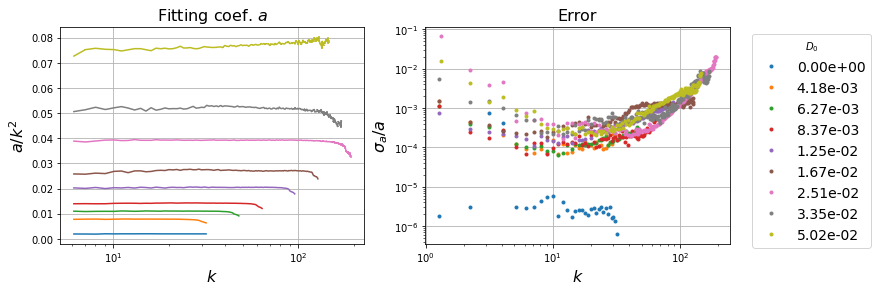

In [78]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
for simu in simulations :
    ax[0].errorbar(simu['k'][5::], (simu['a']/simu['k']**2)[5::], yerr=(simu['a_std_error']/simu['k']**2)[5::])
    ax[1].plot(simu['k'], simu['a_std_error']/simu['a'], '.', label=r'%2.2e' % simu['D0'])
ax[0].set(xlabel=r'$k$', ylabel=r'$a/k^2$', xscale='log', yscale='linear', title=r'Fitting coef. $a$'); ax[0].grid()
ax[1].set(xlabel=r'$k$', ylabel=r'$\sigma_a/a$', xscale='log', yscale='log', title=r'Error'); ax[1].grid()
ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=r'$D_0$')
plt.show()

In [79]:
def find_plateau(data) :
    N = len(data)
    Nmin = N//2
    a = 0; b = N-1
    minAlign = np.max(data-np.mean(data))/float(b-a+1)
    for i in list(range(0, N-Nmin-1)) :
        for j in list(range(i+Nmin, N-1)) :
            newAlign = np.max(data[i:j]-np.mean(data[i:j]))/float(j-i+1)
            if (newAlign < minAlign) :
                minAlign = newAlign
                a = i; b = j
    return np.mean(data[a:b]), np.std(data[a:b]), (b-a+1), a, b

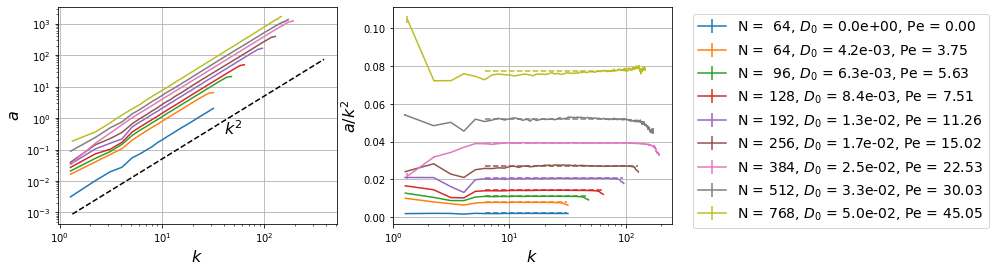

In [80]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(11,4))
for i in range(len(simulations[:])):
    simu = simulations[i]
    simu['plateau_k_max'] = int(((1.47*simu['D0']+simu['diffusivity'])*simu['Te'])**(-0.5))
    sl = np.s_[5:np.min([simu['plateau_k_max'],len(simu['k'])-1])]

    ax[0].errorbar(simu['k'], simu['a'], yerr=simu['a_std_error'], label=r'%2.2e' % simu['D0'])

    simu['plateau_a'] = find_plateau(simu['a'][sl]/(simu['k'][sl]**2))[0]
    simu['std_err_plateau_a'] = np.sqrt(np.sum((simu['a'][sl]/(simu['k'][sl]**2)-simu['plateau_a'])**2)/len(simu['k'][sl]-1))
    ax[1].errorbar(simu['k'], simu['a']/(simu['k']**2), yerr=simu['a_std_error']/(simu['k']**2), \
                   label=r'N = %3.0f, $D_0$ = %2.1e, Pe = %2.2f' % (simu['N'], simu['D0'], simu['Pe']), color=colors[i])
    ax[1].plot(simu['k'][sl], np.full_like(simu['k'][sl], simu['plateau_a']), '--', color=colors[i])

ax[0].plot(simu['k'], 5e-4*simu['k']**2, 'k--')
ax[0].annotate(r'$k^2$', xy=(40, 0.3), xycoords='data', size='16')
ax[0].set(xscale='log', yscale='log', xlabel=r'$k$', ylabel=r'$a$'); ax[0].grid()
#ax.set(ylim=[5e2,10e6])
ax[1].set(xscale='log', yscale='linear', xlabel=r'$k$', ylabel=r'$a/k^2$'); ax[1].grid()
lgd = ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# pp = PdfPages('../Images/Scalar/Sc500_diff_D0_corr_fit_vs_k_.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()

plt.show()

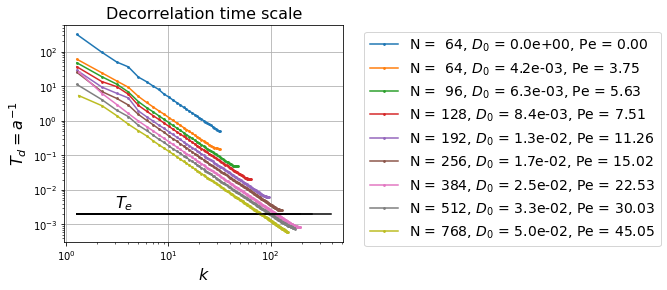

In [81]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))

for i in range(len(simulations)):
    simu = simulations[i]
    ax.plot(simu['k'], (simu['a'])**(-1.0), '.-', label=r'N = %3.0f, $D_0$ = %2.1e, Pe = %2.2f' % (simu['N'], simu['D0'], simu['Pe']), color=colors[i], ms=3.5)
    ax.plot(simu['k'], simu['Te']*np.ones_like(simu['k']), 'k-')
ax.annotate(r'$T_e$', xy=(3, 0.003), xycoords='data', size='16')
ax.set(title='Decorrelation time scale', xscale='log', yscale='log', xlabel=r'$k$', ylabel=r'$T_d = a^{-1}$'); ax.grid()
lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title_fontsize=12)

# pp = PdfPages('../Images/Scalar/Sc500_diff_D0_corr_time_vs_k.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()
plt.show()

## Dependence on $D_0$

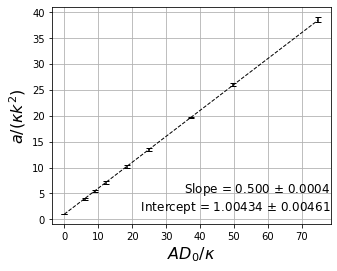

In [82]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
sl = np.s_[:]
x = np.array([simu['A']*simu['D0']/simu['diffusivity'] for simu in simulations[sl]])
y = [(simu['plateau_a']/simu['diffusivity']) for simu in simulations[sl]]
yerr = [(simu['std_err_plateau_a']/simu['diffusivity']) for simu in simulations[sl]]
ax.errorbar(x,y, yerr=yerr, ls='', ms=3, elinewidth=1.5, capsize=3.0, color='k')
ax.set(xlabel=r'$A D_0/\kappa$', ylabel=r'$a/(\kappa k^2)$', xscale='linear', yscale='linear'); ax.grid()

#result_lin_fit = stats.linregress(x, y)
coef, covar = curve_fit(linear_fun, x, y, sigma = yerr, jac=linear_jacobian, absolute_sigma=False)
[slope, intercept]=coef; [slope_stderr,intercept_stderr]=np.sqrt(np.diag(covar))
ax.plot(x, intercept + slope*x, '--', label='fitted line', color='k', lw=1)
ax.text(1.0, 0.2, 'Slope = %2.3f $\pm$ %2.4f \n Intercept = %1.5f $\pm$ %1.5f' % (slope, slope_stderr, intercept, intercept_stderr), {'color': 'k', 'fontsize': 12}, va="top", ha="right", transform=plt.gca().transAxes)
# pp = PdfPages('../Images/Scalar/Sc500_diff_D0_corr_fit_vs_D0.pdf')
# pp.savefig(bbox_inches='tight')
# pp.close()
plt.show()

# Decorrelation at large wave numbers

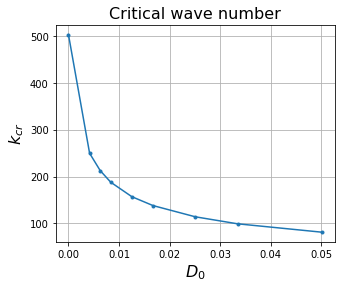

In [83]:
# critical wave number
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
x = np.array([simu['D0'] for simu in simulations])
y = np.array([simu['plateau_k_max'] for simu in simulations])
ax.plot(x,y, marker='.')
ax.set(xlabel=r'$D_0$', ylabel=r'$k_{cr}$', title='Critical wave number'); ax.grid()
plt.show()

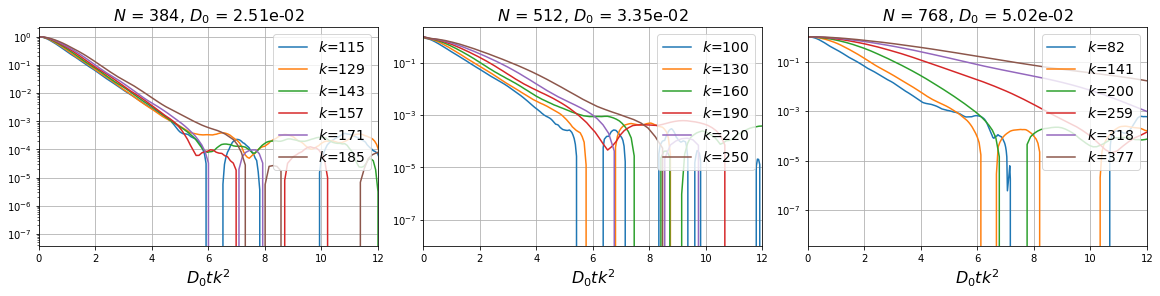

In [84]:
fig, ax = plt.subplots(nrows=1, ncols=3, constrained_layout=True,figsize=(16,4), squeeze=False)
for index, simu in np.ndenumerate(simulations[6:]):
    i = index[0]
    row = i//4; col = i - (row*4)
    kmax = np.max(simu['k'])-6
    kmin = simu['plateau_k_max']
    step = round((kmax - kmin)/nb_of_curves)
    if (kmax > kmin) :
        simu['indices_of_k_to_plot2'] = np.arange(kmin,kmax,step, dtype=np.int16)
        for ik in simu['indices_of_k_to_plot2'] :
            xscaling = simu['D0']*simu['k'][ik]**2
            #xscaling = 1.0
            ax[row,col].plot(simu['t']*xscaling, simu['corr'][:,ik]/simu['corr'][0,ik], '-', label=r'$k$=%2.0f' % (simu['k'][ik]))
        ax[row,col].legend(loc='upper right')
    ax[row,col].set(xscale='linear',yscale='log', xlabel=r'$D_0 t k^2$', title=r'$N$ = %2.0f, $D_0$ = %2.2e' % (simu['N'],simu['D0'])); 
    ax[row,col].grid()
    ax[row,col].set(xlim=[0,12])
plt.show()

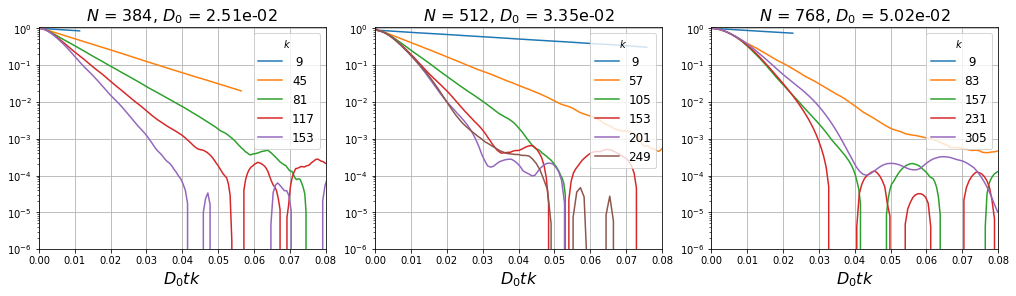

In [85]:
fig, ax = plt.subplots(nrows=1, ncols=3, constrained_layout=True,figsize=(14,4), squeeze=False)
for index, simu in np.ndenumerate(simulations[6:]):
    i = index[0]
    row = i//4; col = i - (row*4)
    kmax = np.max(simu['k'])-6
    kmin = simu['plateau_k_max']
    step = round((kmax - kmin)/nb_of_curves)
    if (kmax > kmin) :
        simu['indices_of_k_to_plot2'] = np.arange(kmin,kmax,step, dtype=np.int16)
        for ik in simu['indices_of_k_to_plot'] :
            xscaling = simu['D0']*simu['k'][ik]
            #xscaling = 1.0
            ax[row,col].plot(simu['t']*xscaling, simu['corr'][:,ik]/simu['corr'][0,ik], '-', label=r'%2.0f' % (simu['k'][ik]))
        ax[row,col].legend(loc='upper right', fontsize=12, title=r'$k$')
    ax[row,col].set(xscale='linear',yscale='log', xlabel=r'$D_0 t k$', title=r'$N$ = %2.0f, $D_0$ = %2.2e' % (simu['N'],simu['D0'])); 
    ax[row,col].grid()
    ax[row,col].set(xlim=[0,0.08], ylim=[1e-6,1.1])
# pp = PdfPages('../Images/Scalar/non_kraichnan_corr_Sc500.pdf')
# pp.savefig(bbox_inches='tight')
# pp.close()
plt.show()

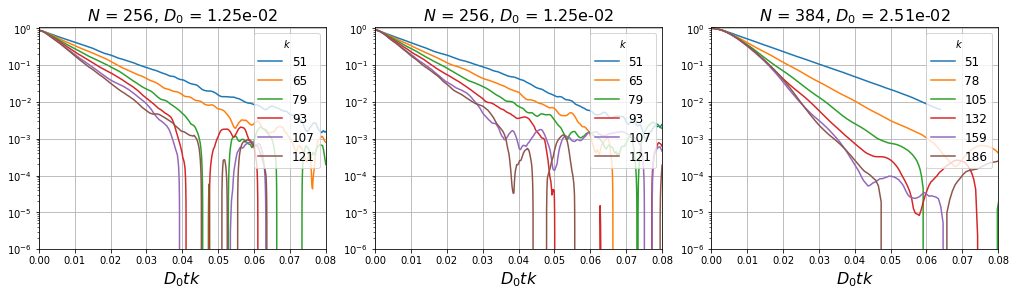

In [86]:
fig, ax = plt.subplots(nrows=1, ncols=3, constrained_layout=True,figsize=(14,4), squeeze=False)
for index, simu in np.ndenumerate(set2[2:]):
    i = index[0]
    row = i//4; col = i - (row*4)
    kmax = np.max(simu['k'])-6
    kmin = 50
    step = round((kmax - kmin)/nb_of_curves)
    if (kmax > kmin) :
        simu['indices_of_k_to_plot2'] = np.arange(kmin,kmax,step, dtype=np.int16)
        for ik in simu['indices_of_k_to_plot2'] :
            xscaling = simu['D0']*simu['k'][ik]
            #xscaling = 1.0
            ax[row,col].plot(simu['t']*xscaling, simu['corr'][:,ik]/simu['corr'][0,ik], '-', label=r'%2.0f' % (simu['k'][ik]))
        ax[row,col].legend(loc='upper right', fontsize=12, title=r'$k$')
    ax[row,col].set(xscale='linear',yscale='log', xlabel=r'$D_0 t k$', title=r'$N$ = %2.0f, $D_0$ = %2.2e' % (simu['N'],simu['D0'])); 
    ax[row,col].grid()
    ax[row,col].set(xlim=[0,0.08], ylim=[1e-6,1.1])
# pp = PdfPages('../Images/Scalar/non_kraichnan_corr_Sc500.pdf')
# pp.savefig(bbox_inches='tight')
# pp.close()
plt.show()

## Crossover

In [87]:
# compute time derivatives of the corr function
for simu in np.concatenate((simulations,set2)) : 
    simu['deriv1'] = np.ndarray(shape=(len(simu['k']), len(simu['t'])), dtype=float)
    simu['deriv2'] = np.ndarray(shape=(len(simu['k']), len(simu['t'])), dtype=float)
    for ik in range(len(simu['k'])) :
        #simu['deriv1'][ik,:] = np.gradient(simu['corr'][:,ik] / simu['corr'][0,ik], simu['t'], edge_order=1)
        simu['deriv1'][ik,:] = np.gradient(np.log(simu['corr'][:,ik]/ simu['corr'][0,ik]), simu['t'], edge_order=1)
        simu['deriv2'][ik,:] = np.gradient(simu['deriv1'][ik,:] / (simu['corr'][:,ik] / simu['corr'][1,ik]), simu['t'], edge_order=1)

/HA/sources/gorbunov8a/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in log
  import sys


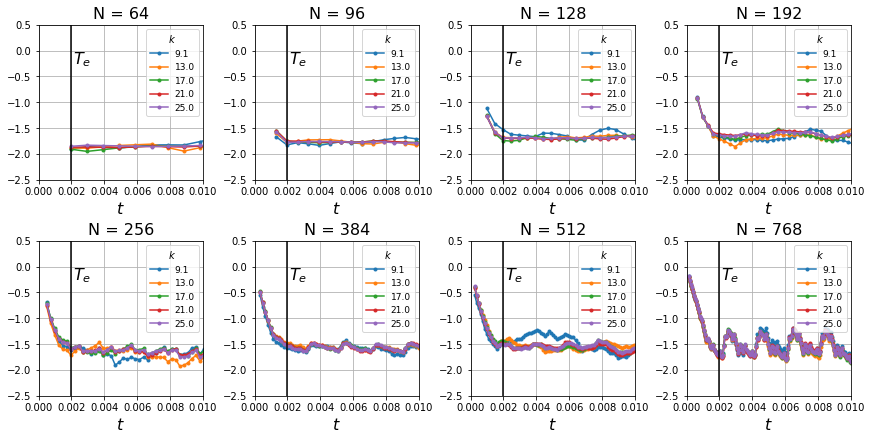

In [88]:
nb_of_rows = 2
nb_of_columns = 4
table = np.arange(1,len(simulations)).reshape(nb_of_rows,nb_of_columns)
fig, ax = plt.subplots(nrows=nb_of_rows, ncols=nb_of_columns, figsize=(nb_of_columns*3,nb_of_rows*3), squeeze=False, constrained_layout=True)
sl=np.s_[2::]
for index, i in np.ndenumerate(table) :
    simu = simulations[i]
    for ik in simulations[0]['indices_of_k_to_plot'] :
    #for ik in simu['indices_of_k_to_plot'] :
        vertical_scaling = 1.0/(simu['k'][ik])**2/simu['D0']
        ax[index].plot(simu['t'][sl]*(simu['k'][ik])**0,simu['deriv1'][ik][sl]*vertical_scaling, \
                marker='.', label='%2.1f' % (simu['k'][ik]))
    ax[index].set(yscale='linear', xlim=[0,0.01], ylim=[-2.5,0.5], xlabel=r'$t$',title='N = %2.0f' % simu['N']); ax[index].grid()
    ax[index].axvline(x=simu['Te'], color='k')
    ax[index].annotate(r'$T_e$', xy=(0.0021, -0.25), xycoords='data', size='16')
    lgd = ax[index].legend(loc='upper right', title=r'$k$', fontsize=9)
#ax[0].set(ylabel=r"$\frac{1}{D_0 C(t,k)} \ \frac{d C(t,k)}{dt}  $")
#pp = PdfPages('../Images/Scalar/Sc500_diff_D0_crossover.pdf')
#pp.savefig(bbox_inches='tight')
#pp.close()
plt.show()

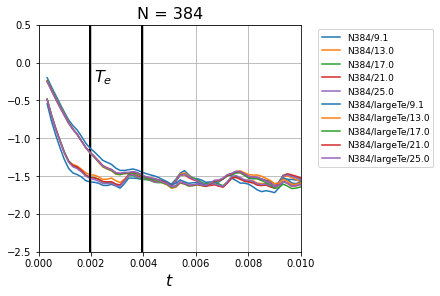

In [46]:
sl=np.s_[2::]
simus_to_plot = [simulations[6],set2[-1]]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4), constrained_layout=True)
for simu in simus_to_plot :
    for i,ik in enumerate(simulations[0]['indices_of_k_to_plot']) :
    #for ik in simu['indices_of_k_to_plot'] :
        vertical_scaling = 1.0/(simu['k'][ik])**2/simu['D0']
        ax.plot(simu['t'][sl]*(simu['k'][ik])**0,simu['deriv1'][ik][sl]*vertical_scaling, \
                label=simu['folder'] + '%2.1f' % (simu['k'][ik]), color=colors[i])
        ax.axvline(x=simu['Te'], color='k')
ax.set(yscale='linear', xlim=[0,0.01], ylim=[-2.5,0.5], xlabel=r'$t$',title='N = %2.0f' % simu['N']); ax.grid()
ax.annotate(r'$T_e$', xy=(0.0021, -0.25), xycoords='data', size='16')
lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
#ax[0].set(ylabel=r"$\frac{1}{D_0 C(t,k)} \ \frac{d C(t,k)}{dt}  $")
#pp = PdfPages('../Images/Scalar/Sc500_diff_D0_crossover.pdf')
#pp.savefig(bbox_inches='tight')
#pp.close()
plt.show()

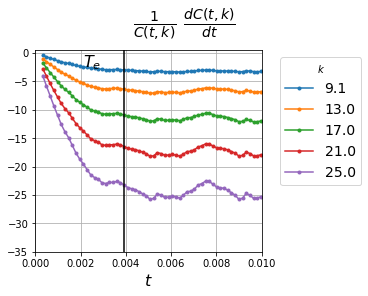

In [47]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4), constrained_layout=True)
sl=np.s_[2::]
tit=fig.suptitle(r'$\frac{1}{C(t,k)} \ \frac{d C (t,k)}{d t}$', fontsize=20)
simu = simulations[7]
simu = set2[-1]
for ik in simulations[0]['indices_of_k_to_plot'] :
    vertical_scaling = 1.0/(simu['k'][ik])**2/simu['D0']
    vertical_scaling = 1.0
    ax.plot(simu['t'][sl]*(simu['k'][ik])**0,simu['deriv1'][ik][sl]*vertical_scaling, \
            marker='.', label='%2.1f' % (simu['k'][ik]))
ax.set(yscale='linear', xlim=[0,0.01], ylim=[-35,0.5], xlabel=r'$t$'); ax.grid()
ax.axvline(x=simu['Te'], color='k')
ax.annotate(r'$T_e$', xy=(0.0021, -2.5), xycoords='data', size='16')
lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=r'$k$')
# pp = PdfPages('../Images/Scalar/derivative_crossover.pdf')
# pp.savefig(bbox_extra_artists=(lgd,tit,), bbox_inches='tight')
# pp.close()
plt.show()

## Gaussian Fit

In [48]:
for simu in np.concatenate((simulations[4::],set2[:])) :
    N = len(simu['t']); Nmin = N//min_coef; Nmax = N-5
    simu['a_gaus'] = np.zeros_like(simu['k'], dtype=float); simu['c_gaus'] = np.zeros_like(simu['k'], dtype=float)
    simu['a_gaus_std_error'] = np.zeros_like(simu['k'], dtype=float); simu['c_gaus_std_error'] = np.zeros_like(simu['k'], dtype=float)
    a = 1
    for ik in list(range(len(simu['k']))) : 
        b = np.searchsorted(simu['t'], 0.9*simu['Te'])
        if (b == 0) : b = Nmax
        if (len(simu['t'][a:b]) > 3) :
            coef, covar = curve_fit(simple_gaussian, simu['t'][a:b], simu['corr'][a:b,ik]/simu['corr'][1,ik], jac=simple_gaussian_jacobian, absolute_sigma=False)
            [simu['a_gaus'][ik], simu['c_gaus'][ik]] = coef
            simu['a_gaus_std_error'][ik], simu['c_gaus_std_error'][ik] = np.sqrt(np.diag(covar))

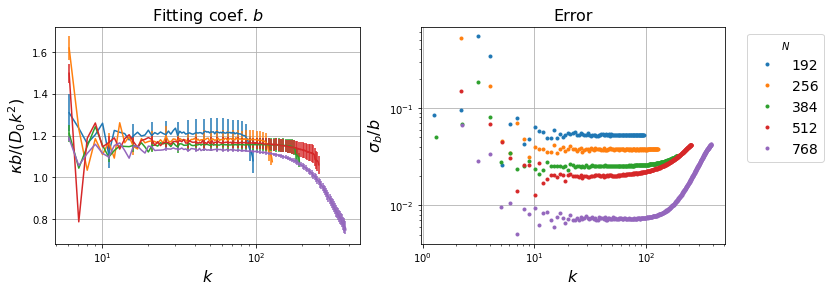

In [49]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
for simu in simulations[4::] :
    ax[0].errorbar(simu['k'][5::], (simu['diffusivity']*simu['a_gaus']/(simu['D0']*simu['k']**2))[5::], yerr=(simu['diffusivity']*simu['a_gaus_std_error']/(simu['D0']*simu['k']**2))[5::], errorevery=5)
    ax[1].plot(simu['k'], simu['a_gaus_std_error']/simu['a_gaus'], '.', label=r'%2.0f' % simu['N'])
ax[0].set(xlabel=r'$k$', ylabel=r'$\kappa b/(D_0 k^2)$', xscale='log', yscale='linear', title=r'Fitting coef. $b$'); ax[0].grid()
ax[1].set(xlabel=r'$k$', ylabel=r'$\sigma_b/b$', xscale='log', yscale='log', title=r'Error'); ax[1].grid()
ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=r'$N$')
# pp = PdfPages('../Images/Scalar/Sc500_diff_D0_gaussian_fit.pdf')
# pp.savefig(bbox_inches='tight')
# pp.close()
plt.show()

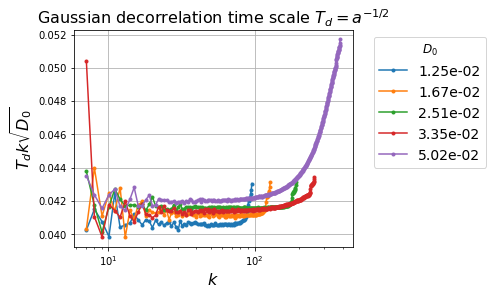

In [50]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
sl = np.s_[6::]
for simu in simulations[4::] :
    vertical_scaling = np.sqrt(simu['D0'])
    ax.plot(simu['k'][sl], (simu['a_gaus'][sl])**(-0.5)*simu['k'][sl]*vertical_scaling, '.-', label=r'%2.2e' % simu['D0'])
#    ax.plot(simu['k'], simu['Te']*simu['k']*vertical_scaling, 'k-')
ax.set(title=r'Gaussian decorrelation time scale $T_d = a^{-1/2}$', xscale='log', yscale='linear', xlabel=r'$k$', ylabel=r'$T_d k \sqrt{D_0}$'); ax.grid()
lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=r'$D_0$', title_fontsize=12)
# pp = PdfPages('../Images/Scalar/corr_time_vs_k_Sc500_diff_D0.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()
plt.show()

## Exponential fit at large time lags after Gaussian

In [51]:
for simu in np.concatenate((simulations[4::],set2[:])) :
    N = len(simu['t']); Nmin = N//min_coef; Nmax = N-5
    simu['a_exp'] = np.zeros_like(simu['k'], dtype=float); simu['c_exp'] = np.zeros_like(simu['k'], dtype=float)
    simu['a_exp_std_error'] = np.zeros_like(simu['k'], dtype=float); simu['c_exp_std_error'] = np.zeros_like(simu['k'], dtype=float)
    a = np.searchsorted(simu['t'], 1.1*simu['Te'])
    for ik in list(range(len(simu['k']))) : 
        b = np.searchsorted(simu['D0']*simu['t']*(simu['k'][ik]**2), tk2_end_fit)
        if (b == 0) : b = Nmax
        if (len(simu['t'][a:b]) > 3) :
            coef, covar = curve_fit(simple_exp, simu['t'][a:b], simu['corr'][a:b,ik]/simu['corr'][0,ik], jac=simple_exp_jacobian, absolute_sigma=False)
            [simu['a_exp'][ik], simu['c_exp'][ik]] = coef
            [simu['a_exp_std_error'][ik], simu['c_exp_std_error'][ik]] = np.sqrt(np.diag(covar))

/tmp/ipykernel_6280/1813181820.py:4: RuntimeWarning: invalid value encountered in true_divide
  ax[1].plot(simu['k'], simu['a_exp_std_error']/simu['a_exp'], '.', label=r'%2.0f' % simu['N'])
/tmp/ipykernel_6280/1813181820.py:4: RuntimeWarning: invalid value encountered in true_divide
  ax[1].plot(simu['k'], simu['a_exp_std_error']/simu['a_exp'], '.', label=r'%2.0f' % simu['N'])


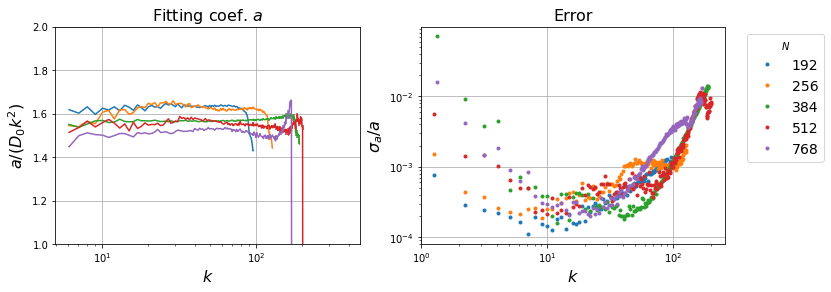

In [52]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
for simu in simulations[4::] :
    ax[0].errorbar(simu['k'][5::], (simu['a_exp']/simu['k']**2)[5::]/simu['D0'], yerr=(simu['a_exp_std_error']/simu['k']**2)[5::]/simu['D0'], errorevery=5)
    ax[1].plot(simu['k'], simu['a_exp_std_error']/simu['a_exp'], '.', label=r'%2.0f' % simu['N'])
ax[0].set(ylim=[1.0,2.0],xlabel=r'$k$', ylabel=r'$a/(D_0 k^2)$', xscale='log', yscale='linear', title=r'Fitting coef. $a$'); ax[0].grid()
ax[1].set(xlabel=r'$k$', ylabel=r'$\sigma_a/a$', xscale='log', yscale='log', title=r'Error'); ax[1].grid()
ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=r'$N$')
plt.show()

## Compare data & Fit



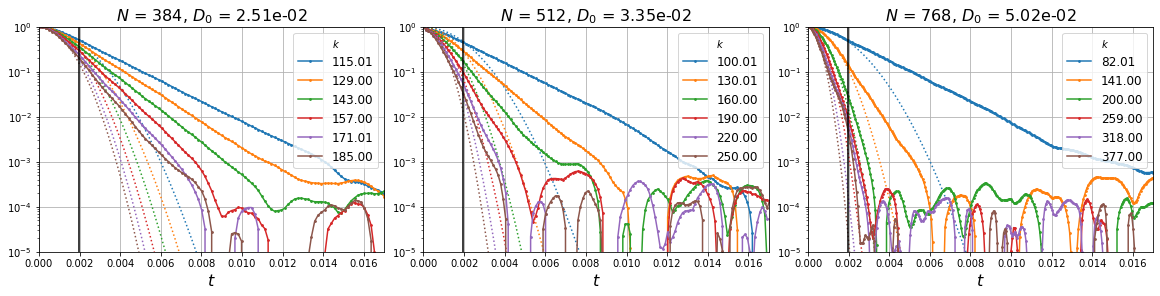

In [53]:
fig, ax = plt.subplots(nrows=1, ncols=3, constrained_layout=True,figsize=(16,4), squeeze=False)
for i, simu in enumerate(simulations[6:]):
    row = i//4; col = i - (row*4)
    kmax = np.max(simu['k'])-6
    kmin = simu['plateau_k_max']
    step = round((kmax - kmin)/nb_of_curves)
    if (kmax > kmin) :
        simu['indices_of_k_to_plot2'] = np.arange(kmin,kmax,step, dtype=np.int16)
        for iik, ik in enumerate(simu['indices_of_k_to_plot2']) :
        #for iik, ik in enumerate(simulations[0]['indices_of_k_to_plot']) :
            xscaling = 1.0
            #xscaling = 1.0
            ax[row,col].plot(simu['t']*xscaling, simu['corr'][:,ik]/simu['corr'][0,ik], '.-', ms=3.5, label=r'%2.2f' % (simu['k'][ik]), color=colors[iik])
            ax[row,col].plot(simu['t']*xscaling, simple_gaussian(simu['t'], simu['a_gaus'][ik],simu['c_gaus'][ik]), ':', color=colors[iik])
            #ax[row,col].plot(simu['t']*xscaling, simple_exp(simu['t'], simu['a_exp'][ik],simu['c_exp'][ik]), ':', color=colors[iik])
        ax[row,col].axvline(x=simu['Te'], color='k')
        ax[row,col].legend(loc='upper right', title=r'$k$', fontsize=12)
    ax[row,col].set(xscale='linear',yscale='log', xlabel=r'$t $', title=r'$N$ = %2.0f, $D_0$ = %2.2e' % (simu['N'],simu['D0'])); 
    ax[row,col].grid()
    ax[row,col].set(xlim=[0,0.017],ylim=[10e-6,1.0])
#pp = PdfPages('../Images/Scalar/Sc500_diff_D0_gaussian_fit_and_data.pdf')
#pp.savefig(bbox_inches='tight')
#pp.close()
plt.show()

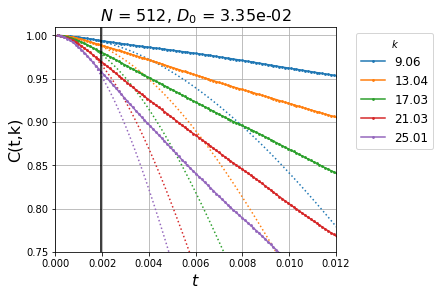

In [54]:
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(6,4))
simu = simulations[7]
kmax = np.max(simu['k'])-6
kmin = simu['plateau_k_max']
step = round((kmax - kmin)/nb_of_curves)
if (kmax > kmin) :
    simu['indices_of_k_to_plot2'] = np.arange(kmin,kmax,step, dtype=np.int16)
    #for iik, ik in enumerate(simu['indices_of_k_to_plot2']) :
    for iik, ik in enumerate(simulations[0]['indices_of_k_to_plot']) :
        xscaling = 1.0
        #xscaling = 1.0
        ax.plot(simu['t'][1:]*xscaling, simu['corr'][1:,ik]/simu['corr'][1,ik], '.-', ms=3.5, label=r'%2.2f' % (simu['k'][ik]), color=colors[iik])
        ax.plot(simu['t']*xscaling, simple_gaussian(simu['t'], simu['a_gaus'][ik],simu['c_gaus'][ik]), ':', color=colors[iik])
        #ax.plot(simu['t']*xscaling, simple_exp(simu['t'], simu['a_exp'][ik],simu['c_exp'][ik]), ':', color=colors[iik])
    ax.axvline(x=simu['Te'], color='k')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=r'$k$', fontsize=12)
ax.set(xscale='linear',yscale='linear', xlabel=r'$t $', ylabel='C(t,k)', title=r'$N$ = %2.0f, $D_0$ = %2.2e' % (simu['N'],simu['D0'])); 
ax.grid()
ax.set(xlim=[0,0.012],ylim=[0.75,1.01])
#pp = PdfPages('../Images/Scalar/correlation_crossover.pdf')
#pp.savefig(bbox_inches='tight')
#pp.close()
plt.show()

# Deviation from Gaussian (testing and adjusting the method for NS results)

In [55]:
threshold = 5e-3
for i,simu in enumerate(np.concatenate((simulations,set2[-1::]))) : 
    simu['it_cut-off'] = np.zeros_like(simu['k'], dtype=int)
    for ik, k in enumerate(simu['k']) :
        small_amplitudes = np.argwhere(simu['corr'][:,ik]/simu['corr'][0,ik]<threshold)
        if (len(small_amplitudes) > 0) :
            simu['it_cut-off'][ik] = small_amplitudes[0,0]
        else :
            simu['it_cut-off'][ik] = len(simu['t']) - 1

In [56]:
threshold_gaussian_deviation = 0.1
for i,simu in enumerate(np.concatenate((simulations[4::],set2[-1::]))) : 
    simu['it_deviation'] = np.zeros_like(simu['k'], dtype=int)
    for ik, k in enumerate(simu['k']) :
        correlations = simu['corr'][2:,ik]/simu['corr'][1,ik]
        x = simu['t']
        gaussian = simple_gaussian(simu['t'], simu['a_gaus'][ik],simu['c_gaus'][ik])[2:]
        large_deviations = np.argwhere(((correlations - gaussian)/gaussian)>threshold_gaussian_deviation)
        if (len(large_deviations) > 0) :
            simu['it_deviation'][ik] = large_deviations[0,0]+2
        else :
            simu['it_deviation'][ik] = len(simu['t']) - 1

/tmp/ipykernel_6280/1104485638.py:8: RuntimeWarning: divide by zero encountered in true_divide
  large_deviations = np.argwhere(((correlations - gaussian)/gaussian)>threshold_gaussian_deviation)
/tmp/ipykernel_6280/1104485638.py:8: RuntimeWarning: overflow encountered in true_divide
  large_deviations = np.argwhere(((correlations - gaussian)/gaussian)>threshold_gaussian_deviation)
/tmp/ipykernel_6280/3781357659.py:2: RuntimeWarning: overflow encountered in exp
  return np.exp(-a * (x)**2.0 + c)
/tmp/ipykernel_6280/1104485638.py:8: RuntimeWarning: invalid value encountered in true_divide
  large_deviations = np.argwhere(((correlations - gaussian)/gaussian)>threshold_gaussian_deviation)


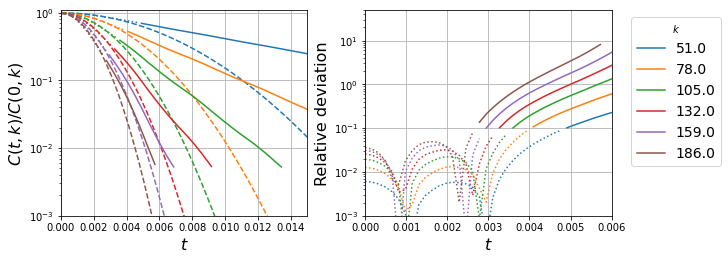

In [57]:
simu = set2[-1]

fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True,figsize=(10,3.5))
fig.suptitle=('Deviation from Gaussian')
for i,ik in enumerate(simu['indices_of_k_to_plot2'][:]) :
    x = simu['t']
    correlations = simu['corr'][:,ik]/simu['corr'][1,ik]
    gaussian = simple_gaussian(simu['t'], simu['a_gaus'][ik],simu['c_gaus'][ik])
    
    time_sl = np.s_[0:simu['it_deviation'][ik]]
    ax[0].plot(x[time_sl], correlations[time_sl], ':', color=colors[i], label='%2.1f' % simu['k'][ik])
    ax[0].plot(x, gaussian, '--', color=colors[i], label='%2.1f' % simu['k'][ik])
    ax[1].plot(x[time_sl], (np.abs(correlations - gaussian)/gaussian)[time_sl], ':', color=colors[i])
    
    time_sl = np.s_[simu['it_deviation'][ik]:simu['it_cut-off'][ik]]
    ax[1].plot(x[time_sl], (np.abs(correlations - gaussian)/gaussian)[time_sl], '-', color=colors[i], label='%2.1f' % simu['k'][ik])
    ax[0].plot(x[time_sl], correlations[time_sl], '-', color=colors[i])

ax[0].set(xscale='linear',yscale='log', xlabel=r'$t$', ylabel=r'$C(t,k)/C(0,k)$'); ax[0].grid()
ax[1].set(xscale='linear',yscale='log', xlabel=r'$t$', ylabel=r'Relative deviation'); ax[1].grid()

x_max = 5.0
ax[0].set(xlim=[0,0.015])
ax[0].set(ylim=[10e-4,1.1])

ax[1].set(xlim=[0,0.006])
ax[1].set(ylim=[10e-4,50])

leg = ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=r'$k$')

# pp = PdfPages('../Images/Scalar/vel_and_scalar_corr_Rl90_Sc07.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()
plt.show()

In [58]:
for i,simu in enumerate(np.concatenate((simulations[4::],set2[-1::]))) : 
    simu['large_time_fit'] = np.zeros([len(simu['k']),2])
    for ik, k in enumerate(simu['k']) :
        time_sl = np.s_[simu['it_deviation'][ik]:simu['it_cut-off'][ik]]
        x = simu['t'][time_sl]
        y = np.log(simu['corr'][time_sl,ik])
        if (len(y) > 0) :
            slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
            simu['large_time_fit'][ik] = [slope, intercept]

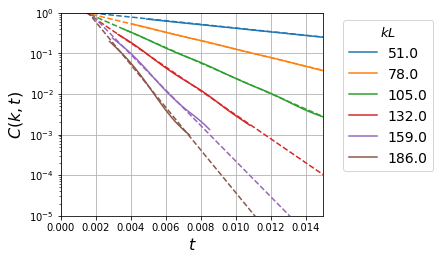

In [59]:
simu = set2[-1]

fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(6,3.5))

k_set = simu['indices_of_k_to_plot2'][:]
for i,ik in enumerate(k_set) :
    horizontal_scaling = 1.0
    time_sl = np.s_[simu['it_deviation'][ik]:simu['it_cut-off'][ik]+10]
    x = simu['t']
    correlations = simu['corr'][:,ik]
    gaussian = simple_gaussian(simu['t'], simu['a_gaus'][ik],simu['c_gaus'][ik])
    
    ax.plot(x[time_sl]*horizontal_scaling, correlations[time_sl]/correlations[1], '-', color=colors[i], label='%2.1f' % (simu['k'][ik]))
    #ax.plot(x*horizontal_scaling, gaussian, ':', color=colors[i])
    ax.plot(x*horizontal_scaling, np.exp(simu['large_time_fit'][ik][0]*simu['t'] + simu['large_time_fit'][ik][1])/correlations[1], '--', color=colors[i])

ax.set(xscale='linear',yscale='log', xlabel=r'$t$', ylabel=r'$C(k,t)$'); ax.grid()

#x_max = simu['corr']['time'][-1]/simu['t0']
#ax.set(xlim=[0,x_max])
ax.set(ylim=[1e-5,1])
ax.set(xlim=[0,0.015])
leg = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=r'$kL$', title_fontsize=13)

# pp = PdfPages('../Images/Scalar/vel_and_scalar_corr_Rl90_Sc07.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()
plt.show()

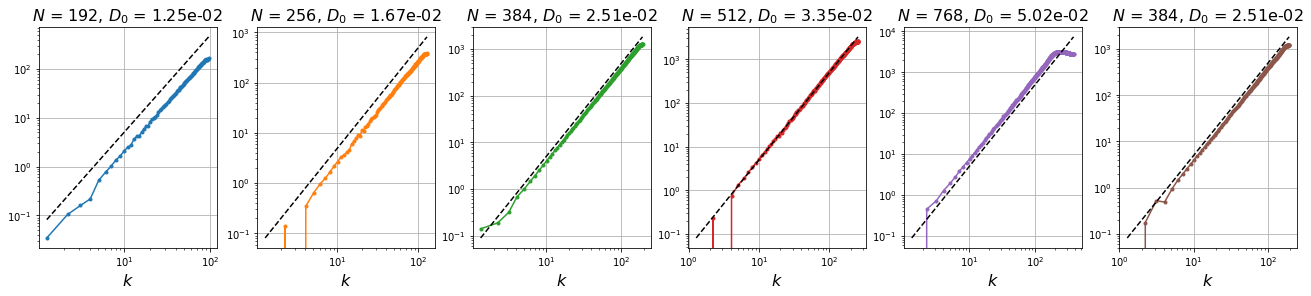

In [60]:
fig, ax = plt.subplots(nrows=1, ncols=len(simulations[4::])+1, constrained_layout=True,figsize=(18,4))

for i,simu in enumerate(np.concatenate((simulations[4::],set2[-1::]))) : 
    ax[i].plot(simu['k'], -simu['large_time_fit'][:,0], '.-', color=colors[i], label='%2.0i' %i)
    ax[i].plot(simu['k'], 5e-2*simu['k']**2, '--', color='k')
#    ax[i].plot(simu['k'], 5e1*simu['k'], '--', color='r')
    ax[i].set(xlabel=r'$k$', title=r'$N$ = %2.0f, $D_0$ = %2.2e' % (simu['N'],simu['D0']), yscale='log', xscale='log'); ax[i].grid()
#     ax[i].set(xlim=[0.03,1.1])
#     ax[i].set(ylim=[15,20000])

plt.show()

# Physical fields

In [61]:
import h5py

# Read scalar fields
for index, simu in np.ndenumerate(simulations[:]):
    try :
        file = h5py.File(common_folder + simu['folder'] + 'run1/' + 'ScalarS1_' + "%06d" % simu['field_ite'] + '.h5', 'r')
        simu['scal_field'] = file['ScalarS1'][:,:] # copy the file data into a numpy array
        file.close()
    except : 
        simu['scal_field'] = np.zeros((simu['N'],simu['N'],simu['N']))

/tmp/ipykernel_6280/3742573716.py:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax[index].pcolormesh(x_scal, x_scal, simu['scal_field'][x_cut, :,:], cmap='jet')


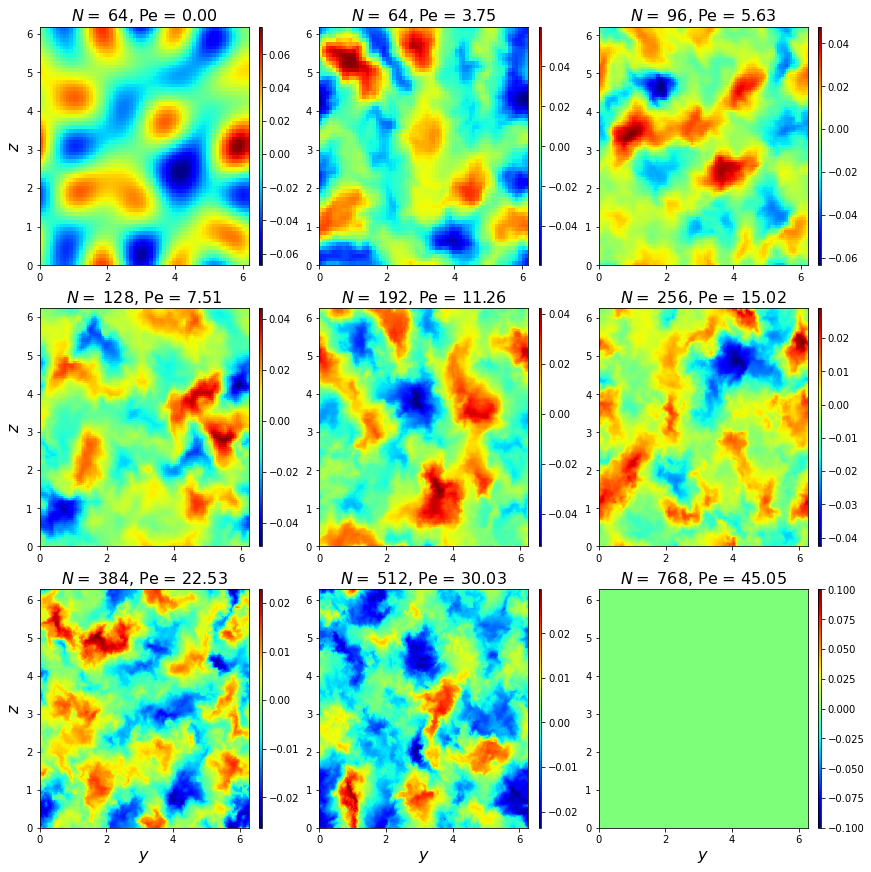

In [62]:
nb_of_rows = 3
nb_of_columns = 3
table = np.arange(len(simulations)).reshape(nb_of_rows,nb_of_columns)

fig, ax = plt.subplots(nrows=nb_of_rows, ncols=nb_of_columns, figsize=(nb_of_columns*4,nb_of_rows*4), squeeze=False, constrained_layout=True)
x_cut=30

for index, isimu in np.ndenumerate(table):
    if (isimu < len(simulations)) : 
        simu = simulations[isimu]
        x_scal = 2.0*np.pi/simu['N']*np.arange(0,simu['N'])
        im = ax[index].pcolormesh(x_scal, x_scal, simu['scal_field'][x_cut, :,:], cmap='jet')
        ax[index].set(xscale='linear', yscale='linear', title=(r'$N = $ %2.0f, Pe = %2.2f' % (simu['N'], simu['Pe'])))
        fig.colorbar(im, ax=ax[index], aspect=100)
        if (index[0] == 2) : ax[index].set(xlabel=r'$y$')
        if (index[1] == 0) : ax[index].set(ylabel=r'$z$')
#plt.savefig("../Images/Scalar/Sc500_diff_D0_scalar_fields.png", dpi=150, format="png")
plt.show()

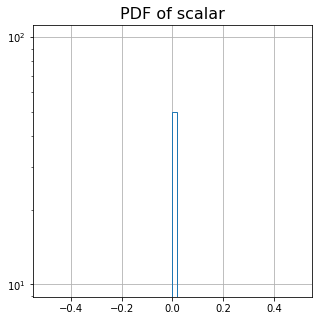

In [63]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
#plot histogram
nb_of_bins=50
simu = simulations[-1]
ax.hist(x=simu['scal_field'].flatten(), bins=nb_of_bins, histtype='step', density=True, log=True, align='mid', label='Scalar %01d' % (index[0] + 1))
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set(title='PDF of scalar'); ax.grid()
plt.show()

In [64]:
for index, simu in np.ndenumerate(set2[:]):
    try :
        file = h5py.File(common_folder + simu['folder'] + 'run1/' + 'ScalarS1_' + "%06d" % simu['field_ite'] + '.h5', 'r')
        simu['scal_field'] = file['ScalarS1'][:,:] # copy the file data into a numpy array
        file.close()
    except : 
        simu['scal_field'] = np.zeros((simu['N'],simu['N'],simu['N']))

/tmp/ipykernel_6280/85852144.py:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax[index].pcolormesh(x_scal, x_scal, simu['scal_field'][x_cut, :,:], cmap='jet')


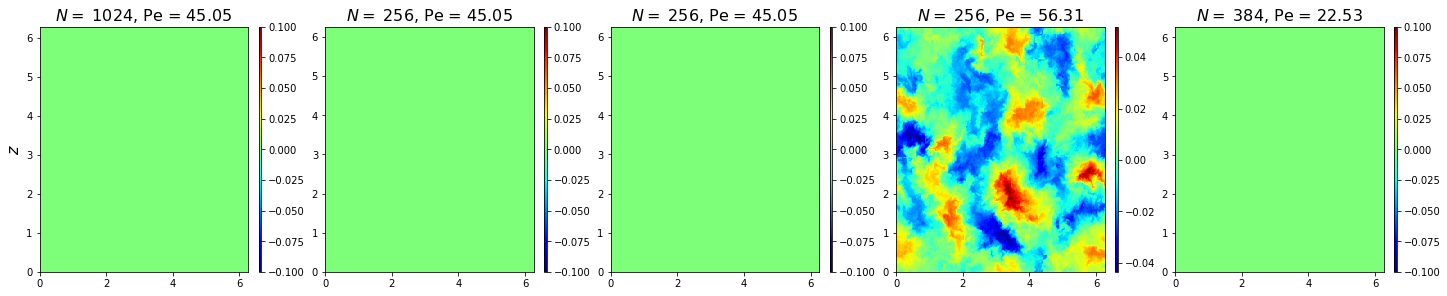

In [65]:
nb_of_rows = 1
nb_of_columns = 5
table = np.arange(len(set2)).reshape(nb_of_rows,nb_of_columns)

fig, ax = plt.subplots(nrows=nb_of_rows, ncols=nb_of_columns, figsize=(nb_of_columns*4,nb_of_rows*4), squeeze=False, constrained_layout=True)
x_cut=30

for index, isimu in np.ndenumerate(table):
    if (isimu < len(set2)) : 
        simu = set2[isimu]
        x_scal = 2.0*np.pi/simu['N']*np.arange(0,simu['N'])
        im = ax[index].pcolormesh(x_scal, x_scal, simu['scal_field'][x_cut, :,:], cmap='jet')
        ax[index].set(xscale='linear', yscale='linear', title=(r'$N = $ %2.0f, Pe = %2.2f' % (simu['N'], simu['Pe'])))
        fig.colorbar(im, ax=ax[index], aspect=100)
        if (index[0] == 2) : ax[index].set(xlabel=r'$y$')
        if (index[1] == 0) : ax[index].set(ylabel=r'$z$')
#plt.savefig("../Images/Scalar/Sc500_diff_D0_scalar_fields.png", dpi=150, format="png")
plt.show()

# Plots for the paper

In [66]:
# Plotting options
plt.rc('axes', labelsize=16)  
plt.rc('axes', titlesize=16)  
plt.rc('legend', fontsize=14, title_fontsize=14)  

In [67]:
bw_cycler2 = cycler(linestyle=['-', '--', ':', '-.'])

In [68]:
bw_cycler = cycler(marker=["o", "s", "^", "*", "D"])
plt.rc('axes', prop_cycle=bw_cycler)

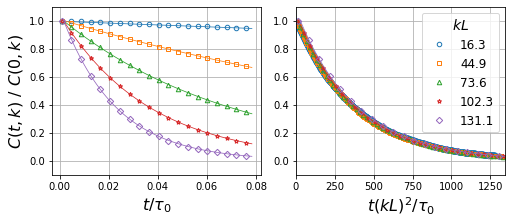

In [69]:
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True,figsize=(7,3))
simu=simulations[4]
for axis in ax : axis.set(prop_cycle=bw_cycler)
sl = np.s_[1:100]
for i,ik in enumerate(simu['indices_of_k_to_plot'][:-1]) :
    xscaling = 1.0/(scalar_L/simu['u'])
    ax[0].plot(simu['t'][sl]*xscaling, simu['corr'][sl,ik]/simu['corr'][1,ik], label=r'%2.1f' % (simu['k'][ik]*scalar_L), \
               ls="", fillstyle='none', ms=4.5, color=colors[i], markevery=5)
    ax[0].plot(simu['t'][2:100]*xscaling, simple_exp(simu['t'][2:100], simu['a'][ik], simu['c'][ik]), '-', color=colors[i], lw = 0.75)
    xscaling = (simu['k'][ik]*scalar_L)**2/(scalar_L/simu['u'])
    ax[1].plot(simu['t'][1:]*xscaling, simu['corr'][1:,ik]/simu['corr'][1,ik], label=r'%2.1f' % (simu['k'][ik]*scalar_L), \
               ls="", fillstyle='none', ms=4.5, color=colors[i], markevery=5)
    ax[1].plot(simu['t'][2:100]*xscaling, simple_exp(simu['t'][2:100], simu['a'][ik], simu['c'][ik]), '-', color=colors[i], lw = 0.75)
ax[0].set(xscale='linear',yscale='linear', xlabel=r'$t/\tau_0$', ylabel=r'$C(t,k) \ / \ C(0,k)$'); ax[0].grid()
ax[0].set(ylim=[-0.1,1.1])
ax[1].set(xscale='linear',yscale='linear', xlabel=r'$t (kL)^2/\tau_0$'); ax[1].grid()
ax[1].set(xlim=[0,simu['t'][sl][-1]*xscaling], ylim=[-0.1,1.1])
ax[1].legend(loc='best', title=r'$k L$', title_fontsize=14, fontsize=12)

# pp = PdfPages('/home/gorbunov8a/Documents/Latex/Papers/paper-prl-scalar/figures/scalarTimeCorrKraichnan.pdf')
# pp.savefig(bbox_inches='tight')
# pp.close()

plt.show()

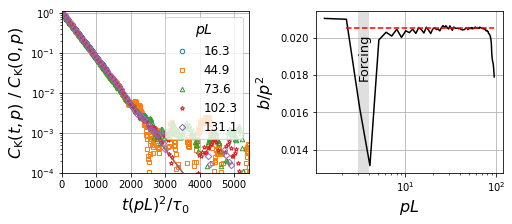

In [70]:
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True,figsize=(7,3))
simu=simulations[4]
sl = np.s_[1:400]
for i,ik in enumerate(simu['indices_of_k_to_plot'][:-1]) :
    xscaling = (simu['k'][ik]*scalar_L)**2/(scalar_L/simu['u'])
    ax[0].plot(simu['t'][1:]*xscaling, simu['corr'][1:,ik]/simu['corr'][1,ik], label=r'%2.1f' % (simu['k'][ik]*scalar_L), \
               ls="", fillstyle='none', ms=4.5, color=colors[i], markevery=5)
    ax[0].plot(simu['t']*xscaling, simple_exp(simu['t'], simu['a'][ik], simu['c'][ik]), '-', color=colors[i], lw = 0.75)
ax[0].set(xscale='linear',yscale='log', xlabel=r'$t (pL)^2/\tau_0$', ylabel=r'$C_{\rm{K}}(t,p) \ / \ C_{\rm{K}}(0,p)$'); ax[0].grid()
ax[0].set(xlim=[0,simu['t'][sl][-1]*xscaling], ylim=[0.0001,1.1])
ax[0].legend(loc='best', title=r'$p L$', title_fontsize=14, fontsize=12)

ax[1].plot(simu['k'], simu['a']/(simu['k']**2), 'k-')
ax[1].plot(simu['k'][sl], np.full_like(simu['k'][sl], simu['plateau_a']), 'r--')
ax[1].set(xscale='log',yscale='linear', xlabel=r'$pL$', ylabel=r'$b/p^2$'); ax[1].grid()
ax[1].axvspan(3.0, 4.0, facecolor='grey', alpha=0.25)
ax[1].text(3.5, 0.019, "Forcing", {'color': 'black', 'fontsize': 13},horizontalalignment='center',verticalalignment='center',rotation=90,clip_on=False)

# pp = PdfPages('/home/gorbunov8a/Documents/Latex/Papers/paper-prl-scalar/figures/scalarTimeCorrKraichnanUPD.pdf')
# pp.savefig(bbox_inches='tight')
# pp.close()

plt.show()

In [71]:
# fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True,figsize=(7,3))
# simu=simulations[4]
# sl = np.s_[1:400]
# for i,ik in enumerate(simu['indices_of_k_to_plot'][:-1]) :
#     xscaling = (simu['k'][ik]*scalar_L)**2/(scalar_L/simu['u'])
#     ax[0].plot(simu['t'][1:]*xscaling, simu['corr'][1:,ik]/simu['corr'][1,ik], label=r'%2.1f' % (simu['k'][ik]*scalar_L), \
#                ls="", fillstyle='none', ms=4.5, color=colors[i], markevery=5)
#     ax[0].plot(simu['t'][2:500]*xscaling, simple_exp(simu['t'][2:500], simu['a'][ik], simu['c'][ik]), '-', color=colors[i], lw = 0.75)
# ax[0].set(xscale='linear',yscale='log', xlabel=r'$t (pL)^2/\tau_0$', ylabel=r'$C(t,p) \ / \ C(0,p)$'); ax[0].grid()
# ax[0].set(xlim=[0,simu['t'][sl][-1]*xscaling], ylim=[0.0001,1.1])
# ax[0].legend(loc='best', title=r'$p L$', title_fontsize=14, fontsize=12)

# ax[1].plot(simu['k'], simu['a'], '.-', color=colors[0])
# ax[1].plot(simu['k'][sl], (simu['k'][sl])**(2), 'k--')
# ax[1].set(xscale='log',yscale='log', xlabel=r'$pL$', ylabel=r'$a/p^2$'); ax[1].grid()
# ax[1].axvspan(3.0, 4.0, facecolor='grey', alpha=0.25)
# ax[1].text(3.5, 10.0, "Forcing", {'color': 'black', 'fontsize': 13},horizontalalignment='center',verticalalignment='center',rotation=90,clip_on=False)

# # pp = PdfPages('/home/gorbunov8a/Documents/Latex/Papers/paper-prl-scalar/figures/scalarTimeCorrKraichnanUPD2.pdf')
# # pp.savefig(bbox_inches='tight')
# # pp.close()

# plt.show()

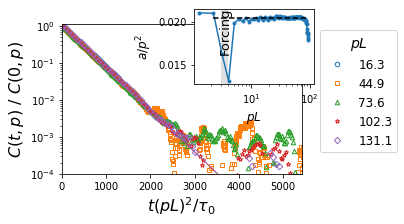

In [72]:
simu = simulations[4]
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(5.5,3))
sl = np.s_[1:400]
for i,ik in enumerate(simu['indices_of_k_to_plot'][:-1]) :
    xscaling = (simu['k'][ik]*scalar_L)**2/(scalar_L/simu['u'])
    ax.plot(simu['t'][1:]*xscaling, simu['corr'][1:,ik]/simu['corr'][1,ik], label=r'%2.1f' % (simu['k'][ik]*scalar_L), \
               ls="", fillstyle='none', ms=4.5, color=colors[i], markevery=5)
    ax.plot(simu['t'][2:500]*xscaling, simple_exp(simu['t'][2:500], simu['a'][ik], simu['c'][ik]), '-', color=colors[i], lw = 0.75)
ax.set(xscale='linear',yscale='log', xlabel=r'$t (pL)^2/\tau_0$', ylabel=r'$C(t,p) \ / \ C(0,p)$'); ax.grid(False)
ax.set(xlim=[0,simu['t'][sl][-1]*xscaling], ylim=[0.0001,1.1])
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=r'$p L$', title_fontsize=14, fontsize=12)

axins = ax.inset_axes([0.55, 0.6, 0.5, 0.50])
axins.tick_params(axis='x', labelsize=10)
axins.plot(simu['k'], simu['a']/(simu['k']**2), '.-', color=colors[0])
axins.plot(simu['k'][sl], np.full_like(simu['k'][sl], simu['plateau_a']), 'k--')
axins.set(xscale='log',yscale='linear'); 
axins.axvspan(3.0, 4.0, facecolor='grey', alpha=0.25)
axins.text(3.5, 0.019, "Forcing", {'color': 'black', 'fontsize': 13},horizontalalignment='center',verticalalignment='center',rotation=90,clip_on=False)
axins.set_ylabel(r'$a/p^2$', fontsize=12)
axins.set_xlabel(r'$pL$', fontsize=12)

# pp = PdfPages('/home/gorbunov8a/Documents/Latex/Papers/paper-prl-scalar/figures/scalarCorrNs.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()

plt.show()

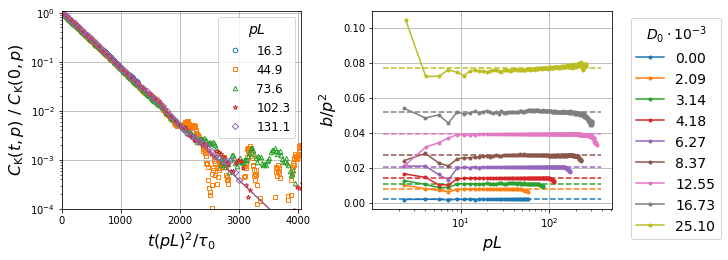

In [73]:
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True,figsize=(10,3.5))
simu=simulations[4]
sl = np.s_[1:300]
for i,ik in enumerate(simu['indices_of_k_to_plot'][:-1]) :
    xscaling = (simu['k'][ik]*scalar_L)**2/(scalar_L/simu['u'])
    ax[0].plot(simu['t'][1:]*xscaling, simu['corr'][1:,ik]/simu['corr'][1,ik], label=r'%2.1f' % (simu['k'][ik]*scalar_L), fillstyle='none', ms=4.5, color=colors[i], markevery=5, ls='')
    ax[0].plot(simu['t'][2:1000]*xscaling, simple_exp(simu['t'][2:1000], simu['a'][ik], simu['c'][ik]), '-', color=colors[i], lw = 0.75)
ax[0].set(xscale='linear',yscale='log', xlabel=r'$t (pL)^2/\tau_0$', ylabel=r'$C_{\rm{K}}(t,p) \ / \ C_{\rm{K}}(0,p)$'); ax[0].grid()
ax[0].set(xlim=[0,simu['t'][sl][-1]*xscaling], ylim=[0.0001,1.1])
ax[0].legend(loc='best', title=r'$p L$', title_fontsize=14, fontsize=12)

for i in range(len(simulations[:])):
    simu = simulations[i]
    sl = np.s_[5:np.min([simu['plateau_k_max'],len(simu['k'])-1])]
    ax[1].plot(simu['k']*scalar_L, simu['a']/(simu['k']**2), '.-', label=r'%2.2f' % (0.5*simu['D0']*1e3), color=colors[i])
    ax[1].plot(simulations[-1]['k'], np.full_like(simulations[-1]['k'], simu['plateau_a']), '--', color=colors[i], lw=1.5)
ax[1].set(xscale='log', yscale='linear', xlabel=r'$pL$', ylabel=r'$b/p^2$'); ax[1].grid()
lgd = ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=r'$D_0\cdot 10^{-3}$')

# pp = PdfPages('/home/gorbunov8a/Documents/Latex/Papers/paper-prl-scalar/figures/scalarTimeCorrKraichnanUPD.pdf')
# pp.savefig(bbox_inches='tight')
# pp.close()
#get_plot_data_blocks(ax,'fig49b_k=')
plt.show()

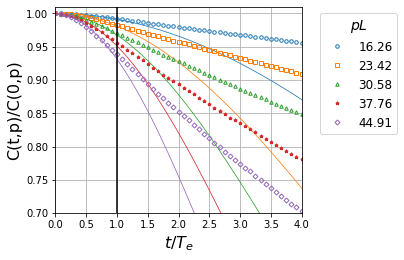

In [74]:
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(5.5,3.5))
simu = set2[-1]
for iik, ik in enumerate(simulations[0]['indices_of_k_to_plot']) :
    xscaling = 1.0/simu['Te']
    ax.plot(simu['t'][0:]*xscaling, simu['corr'][0:,ik]/simu['corr'][0,ik], ms=3.5, label=r'%2.2f' % (simu['k'][ik]*scalar_L), \
            ls="", fillstyle='none', color=colors[iik], markevery=2)
    ax.plot(simu['t']*xscaling, simple_gaussian(simu['t'], simu['a_gaus'][ik],simu['c_gaus'][ik]), '-', color=colors[iik], lw=0.75)
    #ax.plot(simu['t']*xscaling, simple_exp(simu['t'], simu['a_exp'][ik],simu['c_exp'][ik]), ':', color=colors[iik], lw=2.5)
ax.axvline(x=simu['Te']*xscaling, color='k')
#ax.text(0.12, 0.95, "Gaussian", {'color': 'Black', 'fontsize': 13}, horizontalalignment='center', verticalalignment='center', rotation=0, clip_on=False, transform=plt.gca().transAxes)
#ax.text(0.67, 0.95, "Exponential", {'color': 'Black', 'fontsize': 13}, horizontalalignment='center', verticalalignment='center', rotation=0, clip_on=False, transform=plt.gca().transAxes)
lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=r'$pL$', fontsize=12)
ax.set(xscale='linear',yscale='linear', xlabel=r'$t/T_e $', ylabel='C(t,p)/C(0,p)'); 
ax.grid()
ax.set(xlim=[0,4.0],ylim=[0.7,1.01])
# pp = PdfPages('/home/gorbunov8a/Documents/Latex/Papers/paper-prl-scalar/figures/scalarCrossover.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()
plt.show()

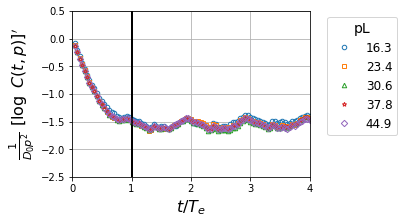

In [75]:
sl=np.s_[1::]
simu = set2[-1]
xscaling = 1.0/simu['Te']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5.5,3), constrained_layout=True)
for i,ik in enumerate(simulations[0]['indices_of_k_to_plot']) :
#for ik in simu['indices_of_k_to_plot'] :
    vertical_scaling = 1.0/(simu['k'][ik])**2/simu['D0']
    #vertical_scaling = 1.0
    ax.plot(simu['t'][sl]*xscaling,simu['deriv1'][ik][sl]*vertical_scaling, label=r'%2.1f' % (simu['k'][ik]*scalar_L), \
           ls="", fillstyle='none', ms=4.5, color=colors[i])
#     ax.plot(simu['t']*xscaling, -2.0*simu['a_gaus'][ik]*simu['t']*vertical_scaling, '-', color=colors[i], lw=0.75)
    ax.axvline(x=simu['Te']*xscaling, color='k')
ax.set(yscale='linear', xlim=[0,4.0], ylim=[-2.5,0.5], xlabel=r'$t/T_e$', ylabel=r'$\frac{1}{D_0 p^2} \ [\log~ C(t,p)]^\prime$'); ax.grid()
#ax.annotate(r'$T_e$', xy=(0.0021, -0.25), xycoords='data', size='16')
lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='pL', fontsize=12)

# pp = PdfPages('/home/gorbunov8a/Documents/Latex/Papers/paper-prl-scalar/figures/scalarCrossover.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()
plt.show()

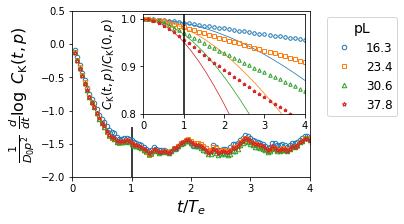

In [76]:
sl=np.s_[1::]
simu = set2[-1]
xscaling = 1.0/simu['Te']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5.5,3), constrained_layout=True)
for i,ik in enumerate(simulations[0]['indices_of_k_to_plot'][:-1]) :
#for ik in simu['indices_of_k_to_plot'] :
    vertical_scaling = 1.0/(simu['k'][ik])**2/simu['D0']
    #vertical_scaling = 1.0
    ax.plot(simu['t'][sl]*xscaling,simu['deriv1'][ik][sl]*vertical_scaling, label=r'%2.1f' % (simu['k'][ik]*scalar_L), \
           ls="", fillstyle='none', ms=4.5, color=colors[i])
#ax.axvline(x=simu['Te']*xscaling, color='k')
ax.vlines(x=simu['Te']*xscaling, ymin=-2.0, ymax=-1.25, color='k')
ax.set(yscale='linear', xlim=[0,4.0], ylim=[-2.0,0.5], xlabel=r'$t/T_e$', ylabel=r'$\frac{1}{D_0 p^2} \ \frac{d}{dt}  \log~ C_{\rm{K}}(t,p)$'); ax.grid(False)

#inset axes....
axins = ax.inset_axes([0.3, 0.38, 0.68, 0.60])

for iik, ik in enumerate(simulations[0]['indices_of_k_to_plot'][:-1]) :
    xscaling = 1.0/simu['Te']
    axins.plot(simu['t'][0:]*xscaling, simu['corr'][0:,ik]/simu['corr'][0,ik], ms=3.5, label=r'%2.2f' % (simu['k'][ik]*scalar_L), \
            ls="", fillstyle='none', color=colors[iik], markevery=3)
    axins.plot(simu['t']*xscaling, simple_gaussian(simu['t'], simu['a_gaus'][ik],simu['c_gaus'][ik]), '-', color=colors[iik], lw=0.75)
    #ax.plot(simu['t']*xscaling, simple_exp(simu['t'], simu['a_exp'][ik],simu['c_exp'][ik]), ':', color=colors[iik], lw=2.5)
axins.set(xscale='linear',yscale='linear'); 
#axins.grid()
axins.set(xlim=[0,4.0],ylim=[0.8,1.01])
axins.axvline(x=simu['Te']*xscaling, color='k')
#axins.set_xlabel(r'$t/T_e $', fontsize=10)
axins.set_ylabel(r'$C_{\rm{K}}(t,p)/C_{\rm{K}}(0,p)$', fontsize=12)
# axins.set_xticklabels('')
# axins.set_yticklabels('')

lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='pL', fontsize=12)

# pp = PdfPages('/home/gorbunov8a/Documents/Latex/Papers/paper-prl-scalar/figures/scalarCrossoverInset.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()
plt.show()

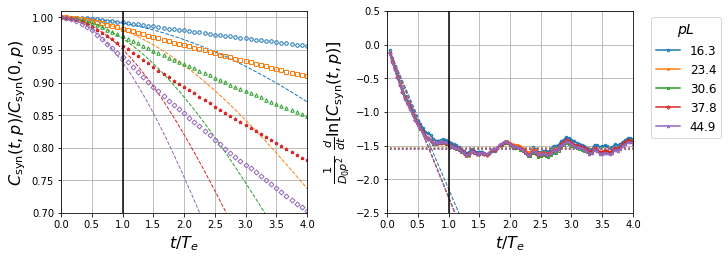

In [90]:
fig, ax = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(10,3.5))
simu = set2[4]
xscaling = 1.0/simu['Te']
#ax[0].text(0.5, 1.03, "Gaussian", {'color': 'Black', 'fontsize': 13}, horizontalalignment='center', verticalalignment='center', rotation=0, clip_on=False)
#ax[0].text(2.0, 1.03, "Exponential", {'color': 'Black', 'fontsize': 13}, horizontalalignment='center', verticalalignment='center', rotation=0, clip_on=False)
for iik, ik in enumerate(simulations[0]['indices_of_k_to_plot']) :
    ax[0].plot(simu['t'][0:]*xscaling, simu['corr'][0:,ik]/simu['corr'][0,ik], ms=3.5, label=r'%2.2f' % (simu['k'][ik]*scalar_L), ls="", fillstyle='none', color=colors[iik], markevery=2)
    ax[0].plot(simu['t']*xscaling, simple_gaussian(simu['t'], simu['a_gaus'][ik],simu['c_gaus'][ik]), '--', color=colors[iik], lw=1.0)
    #ax.plot(simu['t']*xscaling, simple_exp(simu['t'], simu['a_exp'][ik],simu['c_exp'][ik]), '--', color=colors[iik])
    vertical_scaling = 1.0/(simu['k'][ik])**2/simu['D0']
    #vertical_scaling = 1.0
    ax[1].plot(simu['t'][sl]*xscaling,simu['deriv1'][ik][sl]*vertical_scaling, label=r'%2.1f' % (simu['k'][ik]*scalar_L), \
           ls="-", fillstyle='none', ms=2.5, color=colors[iik])
    
    ax[1].plot(simu['t'][sl]*xscaling, -2.*simu['a_gaus'][ik]*simu['t'][sl]*vertical_scaling, ls='--', ms=0, color=colors[iik], lw=1.0)
    ax[1].plot(simu['t'][sl]*xscaling, -np.full_like(simu['t'][sl],simu['a_exp'][ik])*vertical_scaling, ls=':', ms=0, color=colors[iik], lw=1.5)
    
lgd = ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=r'$pL$', fontsize=12)
for axis in ax : 
    axis.axvline(x=simu['Te']*xscaling, color='k')
    axis.set(xlim=[0,4.0],xscale='linear',yscale='linear'); 
    axis.grid()
ax[0].set(xlabel=r'$t/T_e $', ylabel=r'$C_{\rm{syn}}(t,p)/C_{\rm{syn}}(0,p)$', ylim=[0.7,1.01])
ax[1].set(xlabel=r'$t/T_e $', ylabel=r'$\frac{1}{D_0 p^2} \ \frac{d}{dt}{\ln[C_{\rm{syn}}(t,p)]}$', ylim=[-2.5,0.5])
# pp = PdfPages('/home/gorbunov8a/Documents/Latex/Papers/paper-prl-scalar/figures/scalarCrossover.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()
plt.show()

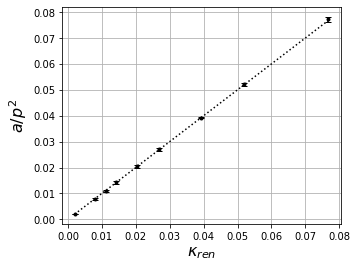

In [78]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
sl = np.s_[:]

x = [kappa_ren(simu['diffusivity'],simu['D0'],simu['A'],3) for simu in simulations[sl]]
y = [simu['plateau_a'] for simu in simulations[sl]]
yerr = [simu['std_err_plateau_a'] for simu in simulations[sl]]
ax.errorbar(x,y, yerr=yerr, ls='', ms=3, elinewidth=1.5, capsize=3.0, color='k')
ax.set(xlabel=r'$\kappa_{ren}$', ylabel=r'$a/p^2$', xscale='linear', yscale='linear'); ax.grid()
ax.plot(x,x,'k:')

# pp = PdfPages('../Images/Scalar/Sc500_diff_D0_corr_fit_vs_D0.pdf')
# pp.savefig(bbox_inches='tight')
# pp.close()
plt.show()

In [79]:
x

[0.002,
 0.007981044798299999,
 0.011128412777825,
 0.014254868013644749,
 0.02050777848425,
 0.0268443399314,
 0.039266509897099997,
 0.05185598181519999,
 0.07678397272279999]

# Plots for thesis

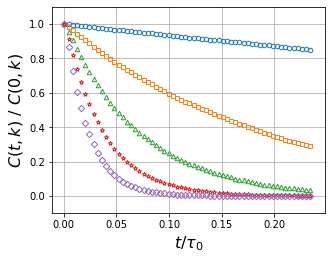

In [80]:
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(4.5,3.5))
simu=simulations[4]
sl = np.s_[1:300]
for i,ik in enumerate(simu['indices_of_k_to_plot'][:-1]) :
    xscaling = 1.0/(scalar_L/simu['u'])
    ax.plot(simu['t'][sl]*xscaling, simu['corr'][sl,ik]/simu['corr'][1,ik], label=r'%2.1f' % (simu['k'][ik]*scalar_L), \
               ls="", fillstyle='none', ms=4.5, color=colors[i], markevery=5)
    #ax.plot(simu['t'][2:100]*xscaling, simple_exp(simu['t'][2:100], simu['a'][ik], simu['c'][ik]), '-', color=colors[i], lw = 0.75)
ax.set(xscale='linear',yscale='linear', xlabel=r'$t/\tau_0$', ylabel=r'$C(t,k) \ / \ C(0,k)$'); ax.grid()
ax.set(ylim=[-0.1,1.1])

# pp = PdfPages('/home/gorbunov8a/Documents/Latex/these/Figures/scalarTimeCorrKraichnan.pdf')
# pp.savefig(bbox_inches='tight')
# pp.close()
#get_plot_data(ax,'fig49a')
plt.show()

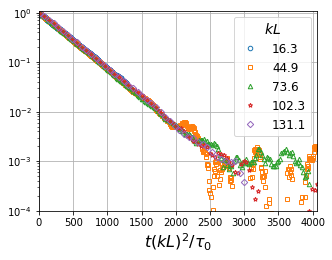

In [81]:
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(4.5,3.5))
simu=simulations[4]
sl = np.s_[1:300]
for i,ik in enumerate(simu['indices_of_k_to_plot'][:-1]) :
    xscaling = (simu['k'][ik]*scalar_L)**2/(scalar_L/simu['u'])
    ax.plot(simu['t'][1:]*xscaling, simu['corr'][1:,ik]/simu['corr'][1,ik], label=r'%2.1f' % (simu['k'][ik]*scalar_L), fillstyle='none', ms=4.5, color=colors[i], markevery=5, ls='')
    #ax.plot(simu['t'][2:1000]*xscaling, simple_exp(simu['t'][2:1000], simu['a'][ik], simu['c'][ik]), '-', color=colors[i], lw = 0.75)
ax.set(xscale='linear',yscale='log', xlabel=r'$t (kL)^2/\tau_0$'); ax.grid()
ax.set(xlim=[0,simu['t'][sl][-1]*xscaling])
ax.set(xlim=[0,simu['t'][sl][-1]*xscaling], ylim=[0.0001,1.1])
ax.legend(loc='best', title=r'$k L$', title_fontsize=14, fontsize=12)

# pp = PdfPages('/home/gorbunov8a/Documents/Latex/these/Figures/scalarTimeCorrKraichnanLog.pdf')
# pp.savefig(bbox_inches='tight')
# pp.close()
#get_plot_data_blocks(ax,'fig49b_k=')
plt.show()

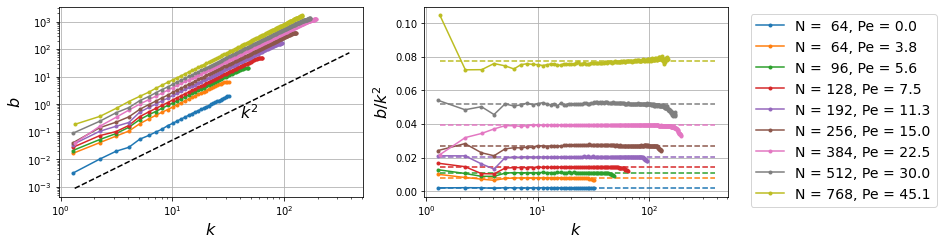

In [82]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,3.5))
for i in range(len(simulations[:])):
    simu = simulations[i]
    simu['plateau_k_max'] = int(((1.47*simu['D0']+simu['diffusivity'])*simu['Te'])**(-0.5))
    sl = np.s_[5:np.min([simu['plateau_k_max'],len(simu['k'])-1])]

    ax[0].plot(simu['k'], simu['a'], marker='.', label=r'%2.2e' % simu['D0'], color=colors[i])

    simu['plateau_a'] = find_plateau(simu['a'][sl]/(simu['k'][sl]**2))[0]
    simu['std_err_plateau_a'] = np.sqrt(np.sum((simu['a'][sl]/(simu['k'][sl]**2)-simu['plateau_a'])**2)/len(simu['k'][sl]-1))
    ax[1].plot(simu['k'], simu['a']/(simu['k']**2), '.-', label=r'N = %3.0f, Pe = %2.1f' % (simu['N'], simu['Pe']), color=colors[i])
    ax[1].plot(simulations[-1]['k'], np.full_like(simulations[-1]['k'], simu['plateau_a']), '--', color=colors[i], lw=1.5)

ax[0].plot(simu['k'], 5e-4*simu['k']**2, 'k--')
ax[0].annotate(r'$k^2$', xy=(40, 0.3), xycoords='data', size='16')
ax[0].set(xscale='log', yscale='log', xlabel=r'$k$', ylabel=r'$b$'); ax[0].grid()
#ax.set(ylim=[5e2,10e6])
ax[1].set(xscale='log', yscale='linear', xlabel=r'$k$', ylabel=r'$b/k^2$'); ax[1].grid()
lgd = ax[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# pp = PdfPages('../Images/Scalar/Sc500_diff_D0_corr_fit_vs_k_.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()

plt.show()

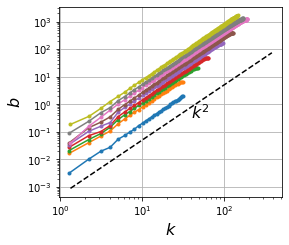

In [83]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,3.5))
for i in range(len(simulations[:])):
    simu = simulations[i]
    ax.plot(simu['k'], simu['a'], marker='.', label=r'%2.2e' % simu['D0'], color=colors[i])
ax.plot(simu['k'], 5e-4*simu['k']**2, 'k--')
ax.annotate(r'$k^2$', xy=(40, 0.3), xycoords='data', size='16')
ax.set(xscale='log', yscale='log', xlabel=r'$k$', ylabel=r'$b$'); ax.grid()

# pp = PdfPages('/home/gorbunov8a/Documents/Latex/these/Figures/kraichnnanbvsk.pdf')
# pp.savefig(bbox_inches='tight')
# pp.close()

plt.show()

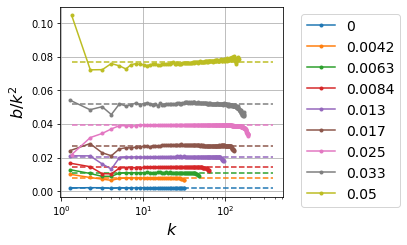

In [89]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,3.5))
for i in range(len(simulations[:])):
    simu = simulations[i]
    simu['plateau_k_max'] = int(((1.47*simu['D0']+simu['diffusivity'])*simu['Te'])**(-0.5))
    sl = np.s_[0:np.min([simu['plateau_k_max'],len(simu['k'])-1])]
    simu['plateau_a'] = find_plateau(simu['a'][sl]/(simu['k'][sl]**2))[0]
    simu['std_err_plateau_a'] = np.sqrt(np.sum((simu['a'][sl]/(simu['k'][sl]**2)-simu['plateau_a'])**2)/len(simu['k'][sl]-1))
    #ax.plot(simu['k'], simu['a']/(simu['k']**2), '.-', label=r'N = %3.0f, $D_0$ = %1.2g' % (simu['N'], simu['D0']), color=colors[i])
    ax.plot(simu['k'], simu['a']/(simu['k']**2), '.-', label=r'%1.2g' % (simu['D0']), color=colors[i])
    ax.plot(simulations[-1]['k'], np.full_like(simulations[-1]['k'], simu['plateau_a']), '--', color=colors[i], lw=1.5)

ax.set(xscale='log', yscale='linear', xlabel=r'$k$', ylabel=r'$b/k^2$'); ax.grid()
lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# pp = PdfPages('/home/gorbunov8a/Documents/Latex/these/Figures/kraichnanbk2vsk.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()
#get_plot_data_blocks(ax,'plateau_fig48b_D0=')
plt.show()

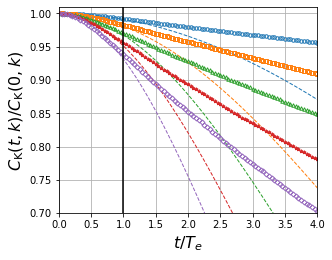

In [85]:
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(4.5,3.5))
simu = set2[-1]
xscaling = 1.0/simu['Te']
for iik, ik in enumerate(simulations[0]['indices_of_k_to_plot']) :
    ax.plot(simu['t'][0:]*xscaling, simu['corr'][0:,ik]/simu['corr'][0,ik], ms=3.5, label=r'%2.2f' % (simu['k'][ik]*scalar_L), ls="", fillstyle='none', color=colors[iik], markevery=1)
    ax.plot(simu['t']*xscaling, simple_gaussian(simu['t'], simu['a_gaus'][ik],simu['c_gaus'][ik]), '--', color=colors[iik], lw=1.0)
    #ax.plot(simu['t']*xscaling, simple_exp(simu['t'], simu['a_exp'][ik],simu['c_exp'][ik]), ':', color=colors[iik])
ax.axvline(x=simu['Te']*xscaling, color='k')
ax.set(xlim=[0,4.0],xscale='linear',yscale='linear'); 
ax.grid()
ax.set(xlabel=r'$t/T_e$',ylabel=r'$C_{\rm{K}}(t,k)/C_{\rm{K}}(0,k)$', ylim=[0.7,1.01])
# pp = PdfPages('/home/gorbunov8a/Documents/Latex/these/Figures/scalarCrossover.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()
#get_plot_data(ax,'fig412a')
plt.show()

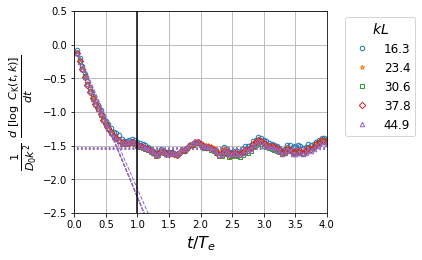

In [86]:
sl=np.s_[1::]
simu = set2[-1]
xscaling = 1.0/simu['Te']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5.75,3.5), constrained_layout=True)
for i,ik in enumerate(simulations[0]['indices_of_k_to_plot']) :
#for ik in simu['indices_of_k_to_plot'] :
    vertical_scaling = 1.0/(simu['k'][ik])**2/simu['D0']
    #vertical_scaling = 1.0
    ax.plot(simu['t'][sl]*xscaling,simu['deriv1'][ik][sl]*vertical_scaling, label=r'%2.1f' % (simu['k'][ik]*scalar_L), \
           ls="", fillstyle='none', ms=4.5, color=colors[i])
    ax.plot(simu['t'][sl]*xscaling, -2.*simu['a_gaus'][ik]*simu['t'][sl]*vertical_scaling, ls='--', ms=0, color=colors[iik], lw=1.0)
    ax.plot(simu['t'][sl]*xscaling, -np.full_like(simu['t'][sl],simu['a_exp'][ik])*vertical_scaling, ls=':', ms=0, color=colors[iik], lw=1.5)
ax.axvline(x=simu['Te']*xscaling, color='k')
ax.set(yscale='linear', xlim=[0,4.0], ylim=[-2.5,0.5], xlabel=r'$t/T_e$', ylabel=r'$\frac{1}{D_0 k^2}~\frac{d~[\log~ C_{\rm{K}}(t,k)]}{d t} $'); ax.grid()
#ax.annotate(r'$T_e$', xy=(0.0021, -0.25), xycoords='data', size='16')
lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=r'$kL$', fontsize=12)

# pp = PdfPages('/home/gorbunov8a/Documents/Latex/these/Figures/scalarCrossoverDeriv.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()
#get_plot_data(ax,'fig412b')
plt.show()

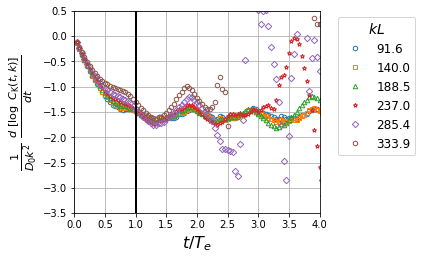

In [87]:
sl=np.s_[1::]
simu = set2[-1]
xscaling = 1.0/simu['Te']
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5.75,3.5), constrained_layout=True)
for i,ik in enumerate(simu['indices_of_k_to_plot2']) :
#for ik in simu['indices_of_k_to_plot'] :
    vertical_scaling = 1.0/(simu['k'][ik])**2/simu['D0']
    #vertical_scaling = 1.0
    ax.plot(simu['t'][sl]*xscaling,simu['deriv1'][ik][sl]*vertical_scaling, label=r'%2.1f' % (simu['k'][ik]*scalar_L), \
           ls="", fillstyle='none', ms=4.5, color=colors[i])
#     ax.plot(simu['t']*xscaling, -2.0*simu['a_gaus'][ik]*simu['t']*vertical_scaling, '-', color=colors[i], lw=0.75)
    ax.axvline(x=simu['Te']*xscaling, color='k')
ax.set(yscale='linear', xlim=[0,4.0], ylim=[-3.5,0.5], xlabel=r'$t/T_e$', ylabel=r'$\frac{1}{D_0 k^2}~\frac{d~[\log~ C_{\rm{K}}(t,k)]}{d t} $'); ax.grid()
#ax.annotate(r'$T_e$', xy=(0.0021, -0.25), xycoords='data', size='16')
lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title=r'$kL$', fontsize=12)

# pp = PdfPages('/home/gorbunov8a/Documents/Latex/these/Figures/scalarCrossoverDeriv.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()
plt.show()

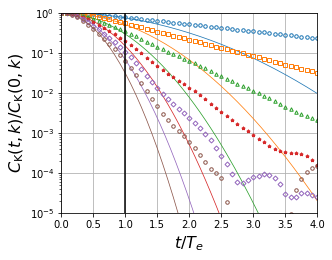

In [88]:
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(4.5,3.5))
simu = set2[-1]
xscaling = 1.0/simu['Te']
for iik, ik in enumerate(simu['indices_of_k_to_plot2']) :
    ax.plot(simu['t'][0:]*xscaling, simu['corr'][0:,ik]/simu['corr'][0,ik], ms=3.5, label=r'%2.2f' % (simu['k'][ik]*scalar_L), ls="", fillstyle='none', color=colors[iik], markevery=2)
    ax.plot(simu['t']*xscaling, simple_gaussian(simu['t'], simu['a_gaus'][ik],simu['c_gaus'][ik]), '-', color=colors[iik], lw=0.75)
    #ax.plot(simu['t']*xscaling, simple_exp(simu['t'], simu['a_exp'][ik],simu['c_exp'][ik]), '--', color=colors[iik])
ax.axvline(x=simu['Te']*xscaling, color='k')
ax.set(xlim=[0,4.0],xscale='linear',yscale='log'); 
ax.grid()
ax.set(xlabel=r'$t/T_e$',ylabel=r'$C_{\rm{K}}(t,k)/C_{\rm{K}}(0,k)$', ylim=[0.00001,1.01])
# pp = PdfPages('/home/gorbunov8a/Documents/Latex/these/Figures/scalarCrossover.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()
plt.show()